In [99]:
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import urllib.request, json
import scipy.stats as stats
import statsmodels.api as sm

from metloom.pointdata import MesowestPointData, SnotelPointData
import dataretrieval.nwis as nwis
import pyet
import metpy.calc as calc
from metpy.units import units


import ftplib
import io
import warnings
import datetime as dt
import xarray as xr


# Visualization
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns


## Functions

In [360]:
def calc_net_lw_radiation(temperature, relative_humidity, elevation, dew_pt_temp=None):
    """Compute net longwave clear sky radiation from temperature measurements, relative humidy values and site elevation


    Args:
        temperature (array-like): mean daily temperatures (C)
        relative_humidity (array-like): mean relative humidity (%)
        elevation (float): site elevation (m)
        dew_pt_temp (array-like, optional): Dew point temperature, include if measured. Defaults to None.

    Returns:
        Series: net longwave radiations in W/m2
    """
    SIGMA = 5.67e-8
    CONSTANT = 40

    # Convert temperature to Kelvin
    temperature_K = temperature.to_xarray().squeeze()+273.15
    temperature_K.attrs = {'units':'K'}


    # Using Marks & Dozier, 1979 to calculate emissivity 
    T_prime = temperature_K + (0.0065 * elevation)
    T_prime.attrs = {'units':'K'}
    e_prime = relative_humidity*calc.saturation_vapor_pressure(T_prime)/100
    
    # Hydrostatic pressure
    standard_p = 101325*((293+(elevation*-0.0065))/293)**(-9.81*0.0299/(-.0065*8.314))
    # Emissivity estimate
    epsilon_atmos=(1.24 * (e_prime/T_prime)**(1/7) * (standard_p)/101300)

    # Longwave in estimate
    lw_in = epsilon_atmos * SIGMA * temperature_K**4 - CONSTANT

    # Calculate longwave out
    if dew_pt_temp is None:
        dew_pt_temp = calc.dewpoint_from_relative_humidity(temperature_K,(relative_humidity/100).to_xarray()).values
    lw_out = SIGMA*(dew_pt_temp+273.15)**4

    # Compute net longwave radiation
    rnet = lw_in - lw_out
    return rnet

def normalize_data(df):
    '''Normalized a pandas series'''
    norm = (df - df.mean())/df.std()
    norm.index = norm.index.astype(int)
    return norm



# Take from https://stackoverflow.com/questions/22852244/how-to-get-the-numerical-fitting-results-when-plotting-a-regression-in-seaborn
def simple_regplot(
    x, y, n_std=2, n_pts=100, ax=None, scatter_kws=None, line_kws=None, ci_kws=None
):
    """ Draw a regression line with error interval. """
    ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    x_fit = sm.add_constant(x)
    fit_results = sm.OLS(y, x_fit).fit()

    eval_x = sm.add_constant(np.linspace(np.min(x), np.max(x), n_pts))
    pred = fit_results.get_prediction(eval_x)

    # draw the fit line and error interval
    ci_kws = {} if ci_kws is None else ci_kws
    ax.fill_between(
        eval_x[:, 1],
        pred.predicted_mean - n_std * pred.se_mean,
        pred.predicted_mean + n_std * pred.se_mean,
        alpha=0.2,
        **ci_kws,
        label='95% CI'
    )
    line_kws = {} if line_kws is None else line_kws
    h = ax.plot(eval_x[:, 1], pred.predicted_mean, **line_kws)

    # draw the scatterplot
    scatter_kws = {} if scatter_kws is None else scatter_kws
    ax.scatter(x, y, c=h[0].get_color(), **scatter_kws)
    ax.legend()
    return fit_results

def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))


In [525]:
def plot_sublimation_discharge_relationship(sites, sublimation_vals, peak_swe_vals,  start_year=1991, end_year=2021, labels=None,savefig=False):    
    """Plots the SWE - Discharge linear regression and the sublimation - discharge(SWE) regression with regression results

    Args:
        sites (dict): dictionary of site names with USGS codes as values
        sublimation_vals (Series): series of annual sublimation values
        peak_swe_vals (Series): series of peak swe values
        start_year (int, optional): start year. Defaults to 1991.
        end_year (int, optional): end year. Defaults to 2021.
        labels (dict, optional): dictionary of swe source and sublimation source for labels. Defaults to None.
        savefig (bool, optional): boolean to save figures. Defaults to False.
    """
    # Used for labeling if not provided
    if labels is None:
        labels = {'swe_source':'Not Specified', 'sublimation_source':'Not Specified'}

    # Normalize swe data and sublimation data
    sntl_max_swe_mm_normalized = normalize_data(peak_swe_vals)
    spring_sublimation_normalized = normalize_data(sublimation_vals.loc[:end_year])
    
    ##### Create figure 1
    fig1, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
    axs = axs.ravel()
    residual_df = pd.DataFrame()

    # Unchanged values
    idx_mask = sntl_max_swe_mm_normalized.loc[start_year:end_year].index
    filtered_max_swe = sntl_max_swe_mm_normalized.loc[idx_mask]
    x=filtered_max_swe.sort_values()
    
    # Iterate over site locations
    for i,site in enumerate(sites):
        # Get monthly mean discharge
        monthly_discharge_stats = nwis.get_stats(sites=sites[site], statReportType='monthly', statTypeCd='mean')[0]
        monthly_discharge_stats = monthly_discharge_stats[monthly_discharge_stats['parameter_cd']==60]

        # Compute annual discharge means
        annual_discharge = monthly_discharge_stats['mean_va'].groupby(monthly_discharge_stats['year_nu']).mean()
        annual_discharge_normalized = normalize_data(annual_discharge)

        # Computes spring discharge means
        spring_discharge_stats = monthly_discharge_stats[monthly_discharge_stats['month_nu'].isin([5,6,7])]
        spring_discharge = spring_discharge_stats['mean_va'].groupby(spring_discharge_stats['year_nu']).mean()
        spring_discharge_normalized = normalize_data(spring_discharge)

        ### Annual Plots
        # get NSE value
        nse_val = nse(annual_discharge_normalized, filtered_max_swe)
        # gets the residuals of the linear regression and plots the linear regression for swe vs discharge as well
        fit_results = simple_regplot(filtered_max_swe,annual_discharge_normalized.loc[idx_mask], ax=axs[i])
        residual_df[site+'_annual'] = fit_results.resid
        axs[i].set_ylabel('Normalized Annual Discharge')
        axs[i].set_xlabel('Normalized Peak SWE')
        axs[i].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - R$^2$={round(fit_results.rsquared,2)}')


        ### Spring Plots
        # get NSE
        nse_val = nse(spring_discharge_normalized, filtered_max_swe)
        # gets the residuals of the linear regression and plots the linear regression for swe vs discharge as well
        fit_results = simple_regplot(filtered_max_swe,spring_discharge_normalized.loc[idx_mask], ax=axs[i+2])
        residual_df[site+'_spring'] = fit_results.resid
        axs[i+2].set_ylabel('Normalized Spring Discharge')
        axs[i+2].set_xlabel('Normalized Peak SWE')
        axs[i+2].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - R$^2$={round(fit_results.rsquared,2)}')
    
        # Annotate with the years
        for j, txt in enumerate(filtered_max_swe.index):
            axs[i].annotate(txt, (filtered_max_swe.iloc[j], annual_discharge_normalized.loc[idx_mask].iloc[j]))
            axs[i+2].annotate(txt, (filtered_max_swe.iloc[j], spring_discharge_normalized.loc[idx_mask].iloc[j]))
    # Add title to figure 1
    fig1.suptitle(f"SWE Data from {labels['swe_source']}", size=20)
    # Save figure if desired
    if savefig is True:
        fig1.savefig(f"../../figures/{labels['swe_source']}-discharge-relationship.png")

    #### Figure 2 - SWE/Discharge residual versus sublimation
    fig2, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
    fig2.patch.set_facecolor('white')
    axs = axs.ravel()
    cols = residual_df.columns

    # Iterate over the columns in the residual dataframe
    for i,col in enumerate([0,2]):
        ### Annual Plots
        # Calculate NSE
        nse_val = nse(spring_sublimation_normalized.loc[residual_df[cols[col]].index], -1*residual_df[cols[col]])
        # Plot and print the regplot results
        fit_results = simple_regplot(spring_sublimation_normalized.loc[residual_df[cols[col]].index], residual_df[cols[col]], ax=axs[i])
        # Add some custimization to the plot
        axs[i].set_ylabel('Normalized Discharge(Peak SWE) Residual')
        axs[i].set_xlabel(labels['xlabel'])
        axs[i].set_title(f"{cols[col].replace('_',' ').upper()}\n R$^2$={round(fit_results.rsquared,2)}")

        ### Spring Plots
        # Calculate NSE
        nse_val = nse(spring_sublimation_normalized.loc[residual_df[cols[col+1]].index],-1*residual_df[cols[col+1]])
        # Plot and pring the regplot results
        fit_results = simple_regplot(spring_sublimation_normalized.loc[residual_df[cols[col+1]].index], residual_df[cols[col+1]], ax=axs[i+2])
        axs[i+2].set_ylabel('Normalized Discharge(Peak SWE) Residual')
        axs[i+2].set_xlabel(labels['xlabel'])
        axs[i+2].set_title(f"{cols[col+1].replace('_',' ').upper()}\n R$^2$={round(fit_results.rsquared,2)}")

        # Annotate with the years
        for j, txt in enumerate(residual_df[cols[i]].index):
            axs[i].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col]].index].iloc[j], residual_df[cols[col]].iloc[j]))
            axs[i+2].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col+1]].index].iloc[j], residual_df[cols[col+1]].iloc[j]))
    
    # Add figure title
    fig2.suptitle(f"SWE Data from {labels['swe_source']} and Sublimation Estimate from {labels['sublimation_source']}", size=20)
    # save figure if desired
    if savefig is True:
        fig2.savefig(f"../../figures/{labels['swe_source']}_vs_{labels['sublimation_source']}.png")
    return

## Precip, max temp, min temp, and snow from 1910-2022

In [101]:
gunnison_df = pd.read_json(r"C:\Users\dlhogan\Downloads\html-to-json-converter.json")

# Fix and convert max temp 
gunnison_df['maxt'] = (gunnison_df['maxt'].replace({'M':np.nan,'-0':'0'}).astype(float) - 32) * 5/9
# Fix and convert min temp

gunnison_df['mint'] = (gunnison_df['mint'].replace({'M':np.nan,'-0':'0'}).astype(float) - 32) * 5/9
# Fix and convert precip
gunnison_df['pcpn'] = gunnison_df['pcpn'].str.replace("A","")
gunnison_df['pcpn'] = gunnison_df['pcpn'].replace({'M':np.nan,'S':np.nan,'T':'0'}).astype(float) * 25.4
# Fix and convert snow
gunnison_df['snow'] = gunnison_df['snow'].str.replace("A","")
gunnison_df['snow'] = gunnison_df['snow'].replace({'M':np.nan,'S':np.nan,'T':'0'}).astype(float) * 25.4

gunnison_df.set_index('gunnison 3 sw', inplace=True)
gunnison_df.index = pd.to_datetime(gunnison_df.index)

winter_gunnison_df = gunnison_df.loc[gunnison_df.index.month < 5 | ((gunnison_df.index.month == 12) & (gunnison_df.index.day > 21)) ]

In [102]:
# winter_gunnison_df['wspd'] = winter_taylor_park_df['WSpd']
# winter_gunnison_df['wspd'] = winter_gunnison_df['wspd'].fillna( winter_taylor_park_df['WSpd'].median())
winter_gunnison_df=winter_gunnison_df.interpolate(method='from_derivatives', order=2)


In [104]:
mean_temp = ((winter_gunnison_df['maxt'] + winter_gunnison_df['mint'])/2).to_xarray() * units("celsius")

rh = 100*calc.relative_humidity_from_dewpoint(temperature=mean_temp, dewpoint=winter_gunnison_df['mint'].to_xarray() * units("celsius")) * units('percent')
net_gunnison_winter = calc_net_lw_radiation(temperature=mean_temp.to_pandas(), 
                      relative_humidity=rh.to_pandas()*1.05,
                      elevation=3000
                        )

# Calculate Penman-Monteith "sublimation"
sublimation_gunnison_pm = pyet.pm(tmean=mean_temp.to_numpy(),
        wind=2.1,#winter_gunnison_df["wspd"],
        rh=rh.to_numpy()*1.05,
        rn=net_gunnison_winter*3600*24/1e6 ,
        elevation=3000,
        r_l=0,
        r_s=400,
        ra_method=1)


sublimation_gunnison_pm_df = sublimation_gunnison_pm.to_frame(name='sublimation_mm')
sublimation_gunnison_pm_df['water_year'] =  sublimation_gunnison_pm_df.index.year.where(sublimation_gunnison_pm_df.index.month < 10, sublimation_gunnison_pm_df.index.year + 1)
sublimation_gunnison_totals = sublimation_gunnison_pm_df['sublimation_mm'].groupby(sublimation_gunnison_pm_df['water_year']).sum()
sublimation_gunnison_totals.rename = 'sublimation'

## Pulls daily data from station in Gunnison 2015-2022

In [689]:
with urllib.request.urlopen("https://coagmet.colostate.edu/data/daily/gun01.json?from=start&to=end&tz=utc&units=m") as url:
    gun01_df = pd.DataFrame(json.loads(url.read().decode()))
gun01_df = gun01_df.set_index('time')
gun01_df.index = pd.to_datetime(gun01_df.index)
gun01_df['water_year'] =  gun01_df.index.year.where(gun01_df.index.month < 10, gun01_df.index.year + 1)

In [741]:
winter_df = gun01_df[(gun01_df['etrASCE']>=0) & ((gun01_df.index.month>=12) | (gun01_df.index.month<4))]
summer_df = gun01_df[(gun01_df['etrASCE']>=0) & ((gun01_df.index.month>=6) & (gun01_df.index.month<10))]

winter_et_gun01 = winter_df.groupby(winter_df.water_year).sum()['etrASCE']
winter_et_gun01.name = 'winter'
summer_et_gun01 = summer_df.groupby(summer_df.water_year).sum()['etrASCE']
summer_et_gun01.name = 'summer'

et_gun01 = gun01_df[(gun01_df['etrASCE']>=0)].groupby(gun01_df[(gun01_df['etrASCE']>=0)].water_year).sum()['etrASCE']




## Pulls daily met data for Gunnison Airport from 1997-2022

In [105]:
start_year = 1995
end_year = 2022
meso_point = MesowestPointData("KGUC", "GunnisonAirport")
kguc_df = meso_point.get_daily_data(
    datetime(start_year, 1, 1), datetime(end_year, 5, 1),
    [meso_point.ALLOWED_VARIABLES.DEWPOINT,
     meso_point.ALLOWED_VARIABLES.NETLONGWAVE,
     meso_point.ALLOWED_VARIABLES.NETSHORTWAVE,
     meso_point.ALLOWED_VARIABLES.PRESSURE,
     meso_point.ALLOWED_VARIABLES.RH,
     meso_point.ALLOWED_VARIABLES.SNOWDEPTH,
     meso_point.ALLOWED_VARIABLES.SOILTEMP,
     meso_point.ALLOWED_VARIABLES.SOILTEMPIR,
     meso_point.ALLOWED_VARIABLES.SOLARRADIATION,
     meso_point.ALLOWED_VARIABLES.SWE,
     meso_point.ALLOWED_VARIABLES.TEMP,
     meso_point.ALLOWED_VARIABLES.WETBULBTEMPERATURE,
     meso_point.ALLOWED_VARIABLES.WINDDIRECTION,
     meso_point.ALLOWED_VARIABLES.WINDSPEED]
)


Filter to only winter values. 

**Note if pressure values are desired, they are errant for much of this data set**

In [440]:
winter_kguc_df = kguc_df.droplevel(1).loc[kguc_df.droplevel(1).index.month < 5 | ((kguc_df.droplevel(1).index.month == 12) & (kguc_df.droplevel(1).index.day > 21)) ]

Compute net clear sky longwave radiation for Gunnison airport data:

In [441]:
net_kguc_winter = calc_net_lw_radiation(temperature=winter_kguc_df['AIR TEMP'], 
                      relative_humidity=winter_kguc_df['RELATIVE HUMIDITY'],
                      elevation=winter_kguc_df['geometry'].z.unique()[0]/3.28,
                      dew_pt_temp=winter_kguc_df['DEW POINT TEMPERATURE']
                        )

Run the Penman-Monteith method on Gunnison Airport data

In [442]:
# Calculate Penman-Monteith "sublimation"
sublimation_kguc_pm = pyet.pm(tmean=winter_kguc_df['AIR TEMP'],
        wind=winter_kguc_df['WIND SPEED'],
        rh=winter_kguc_df['RELATIVE HUMIDITY'],
        rn=net_kguc_winter*3600*24/1e6 ,
        elevation=winter_kguc_df['geometry'].z.unique()[0]/3.28,
        r_l=0,
        r_s=400,
        ra_method=1)


sublimation_kguc_pm_df = sublimation_kguc_pm.to_frame(name='sublimation_mm')
sublimation_kguc_pm_df['water_year'] =  sublimation_kguc_pm_df.index.year.where(sublimation_kguc_pm_df.index.month < 10, sublimation_kguc_pm_df.index.year + 1)
sublimation_kguc_totals = sublimation_kguc_pm_df['sublimation_mm'].groupby(sublimation_kguc_pm_df['water_year']).sum()
sublimation_kguc_totals.rename = 'sublimation'

## Taylor Park Met Data 1988-2021

In [489]:
# Get data and filter appropriately
taylor_park_df = pd.read_csv('data/taylor_park_daily_met.txt',sep='\s+')
taylor_park_elev = 3201
taylor_park_df = taylor_park_df.set_index('Date')
taylor_park_df = taylor_park_df.replace(-9999,np.nan)
taylor_park_df.index = pd.to_datetime(taylor_park_df.index)
taylor_park_df['Year'] =  taylor_park_df.index.year.where(taylor_park_df.index.month < 10, taylor_park_df.index.year + 1)
taylor_park_df = taylor_park_df.rename(columns={'Year':'Water_Yr'})

# Calculated lw net and winterize the data
winter_taylor_park_df = taylor_park_df.loc[taylor_park_df.index.month < 5 | ((taylor_park_df.index.month > 12)) ]
net_taylor_winter = calc_net_lw_radiation(temperature=winter_taylor_park_df['AveT'], 
                      relative_humidity=winter_taylor_park_df['AveRH'],
                      elevation=taylor_park_elev
                        )


In [490]:
sublimation_taylor_pm = pyet.pm(tmean=winter_taylor_park_df['AveT'],
        tmax=winter_taylor_park_df['MaxT'],
        tmin=winter_taylor_park_df['MinT'],
        rhmax=winter_taylor_park_df['MaxRH'],
        rhmin=winter_taylor_park_df['MinRH'],
        wind=winter_taylor_park_df['WSpd'],
        rh=winter_taylor_park_df['AveRH'],
        rn=net_taylor_winter*3600*24/1e6 ,
        elevation=taylor_park_elev,
        r_l=0,
        r_s=400,
        ra_method=1)
sublimation_taylor_pm_df = sublimation_taylor_pm.to_frame(name='sublimation_mm')
sublimation_taylor_pm_df['water_year'] =  sublimation_taylor_pm_df.index.year.where(sublimation_taylor_pm_df.index.month < 10, sublimation_taylor_pm_df.index.year + 1)
sublimation_taylor_totals = sublimation_taylor_pm_df['sublimation_mm'].groupby(sublimation_taylor_pm_df['water_year']).sum()
sublimation_taylor_totals.rename = 'sublimation'        

## Get Snotel or Snow Course Data

Compute estimated sublimation at Taylor Park

Pull daily snotel point data from 1991-2022 from Butte snotel station

In [111]:
snotel_point = SnotelPointData("380:CO:SNTL", "Butte")
butte_df = snotel_point.get_daily_data(
    datetime(1991, 1, 1), datetime(2021, 6, 1),
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATION,
     snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM,
     snotel_point.ALLOWED_VARIABLES.SNOWDEPTH,
     snotel_point.ALLOWED_VARIABLES.SWE,
     snotel_point.ALLOWED_VARIABLES.TEMP]
)
butte_df = butte_df.droplevel(1)

# Add water year
butte_df['water_year'] =  butte_df.index.year.where(butte_df.index.month < 10, butte_df.index.year + 1)

# Get max swe
butte_max_swe_mm = butte_df['SWE'].groupby(butte_df.index.year).max()*25.4

Get Park Cone snotel data starting in 1991

In [466]:
snotel_point = SnotelPointData("680:CO:SNTL", "ParkCone")
park_cone_df = snotel_point.get_daily_data(
    datetime(1991, 10, 1), datetime(2021, 9, 30),
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATION,
     snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM,
     snotel_point.ALLOWED_VARIABLES.SNOWDEPTH,
     snotel_point.ALLOWED_VARIABLES.SWE,
     snotel_point.ALLOWED_VARIABLES.TEMP]
)
park_cone_df = park_cone_df.droplevel(1)

# Get water year for Park Cone data
park_cone_df['water_year'] =  park_cone_df.index.year.where(park_cone_df.index.month < 10, park_cone_df.index.year + 1).astype(int)

# Calculate max swe
park_cone_max_swe_mm = park_cone_df['SWE'].groupby(park_cone_df.index.year).max()*25.4

In [113]:
park_cone_apr1_swe_mm = park_cone_df.loc[(park_cone_df.index.month==4) & (park_cone_df.index.day==1)][['SWE','water_year']]
park_cone_apr1_swe_mm = park_cone_apr1_swe_mm['SWE'].groupby(park_cone_apr1_swe_mm.index.year).mean()*25.4

Get Crested Butte snow course data starting in 1936

In [114]:

snowcourse_point = SnotelPointData("07L01:CO:SNOW", "CrestedButte")
crested_butte_df = snowcourse_point.get_snow_course_data(datetime(1936,2,1),datetime(2021,5,1), [snowcourse_point.ALLOWED_VARIABLES.SWE]).droplevel(1)

# Get water year for Crested Butte data
crested_butte_df['water_year'] =  crested_butte_df.index.year.where(crested_butte_df.index.month < 10, crested_butte_df.index.year + 1).astype(int)

# Calculate max swe (mm)
crested_butte_max_swe_mm = crested_butte_df['SWE'].groupby(crested_butte_df.index.year).max()*25.4

# Fill in missing point with nearby snow course
crested_butte_max_swe_mm[2001]=13.3*25.4
crested_butte_max_swe_mm[2002]=9.0*25.4
crested_butte_max_swe_mm[2003]=15.3*25.4

Could not find timezone info for 07L01:CO:SNOW (CrestedButte)


## Discharge, Peak SWE and Sublimation Relationships
### Results using Butte Snotel and KGUC Sublimation

In [534]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}

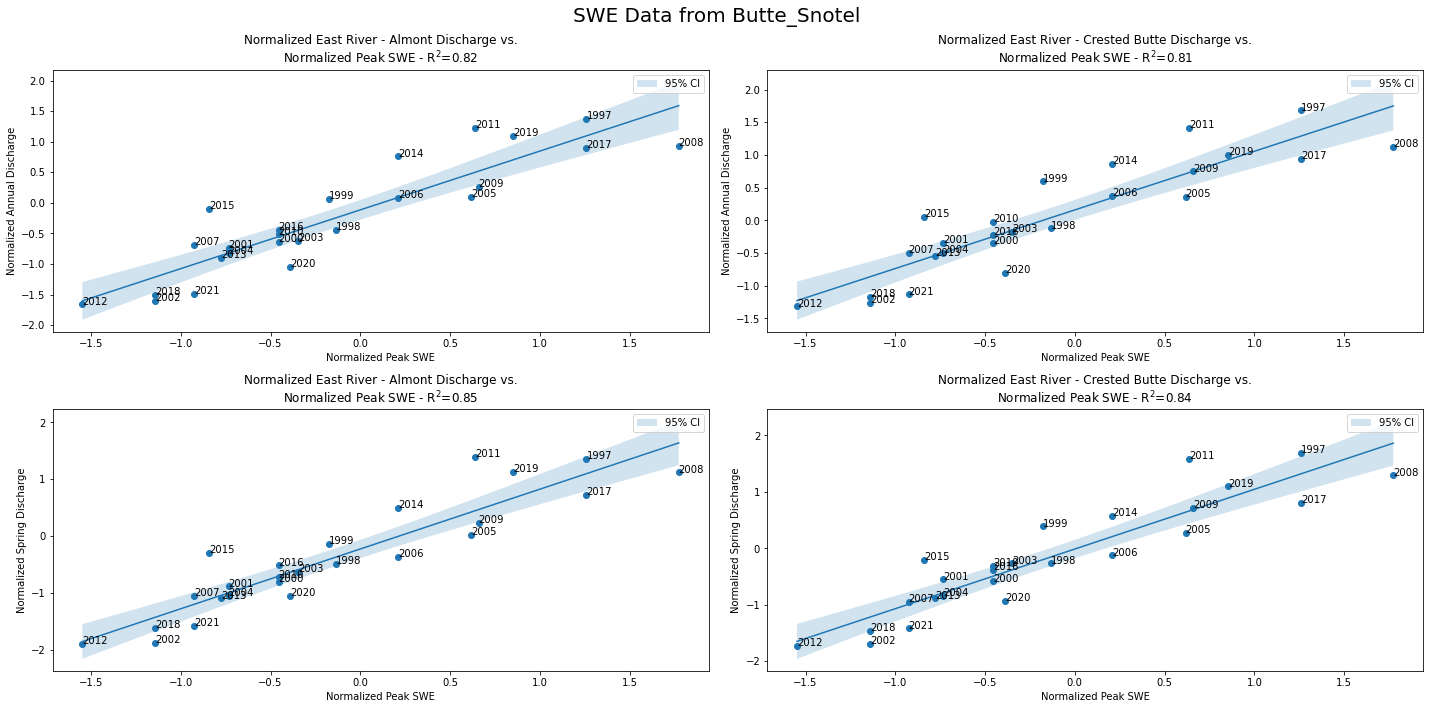

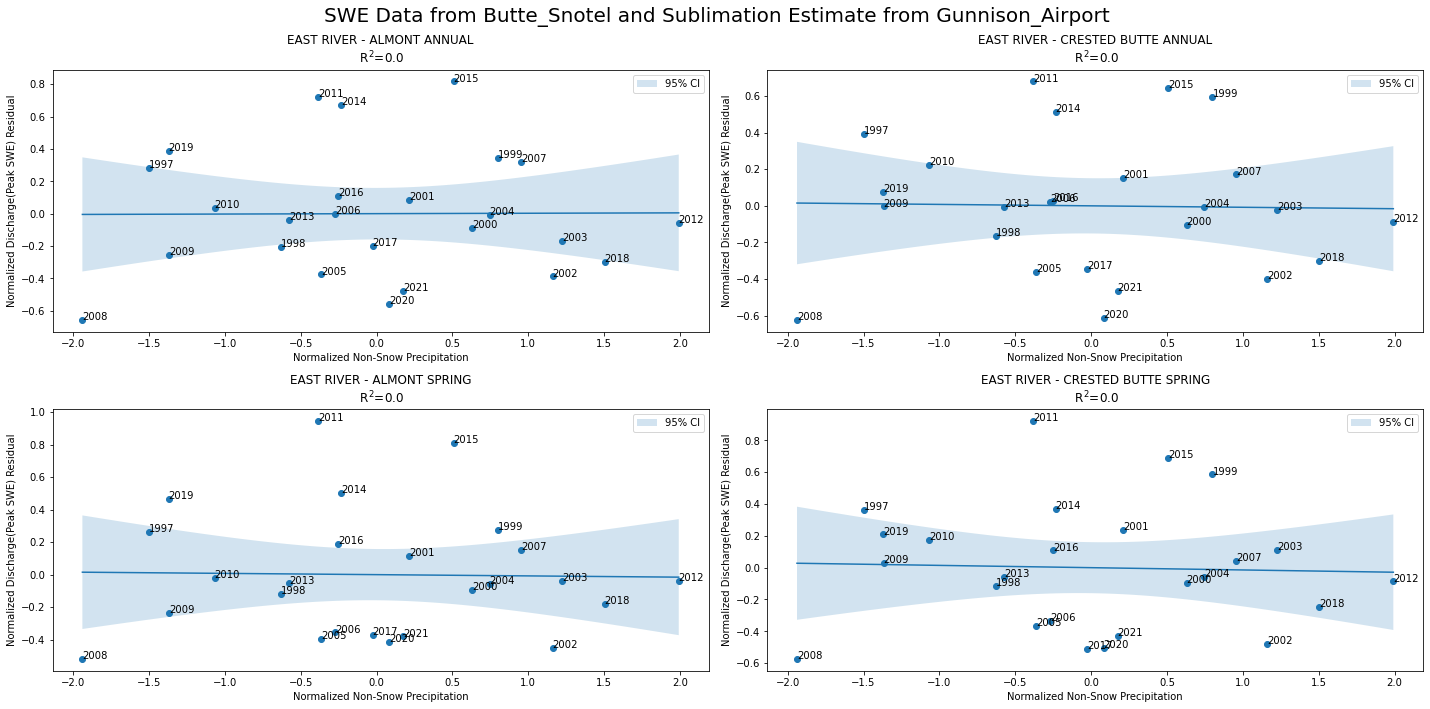

In [721]:
plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=sublimation_kguc_totals,
                                        peak_swe_vals=butte_max_swe_mm,
                                        start_year=1997,
                                        labels={'swe_source':'Butte_Snotel',
                                                'sublimation_source':'Gunnison_Airport',
                                                'xlabel':'Normalized Non-Snow Precipitation'})

### Results using Park Cone Snotel and Taylor Park Sublimation (1991-2021)

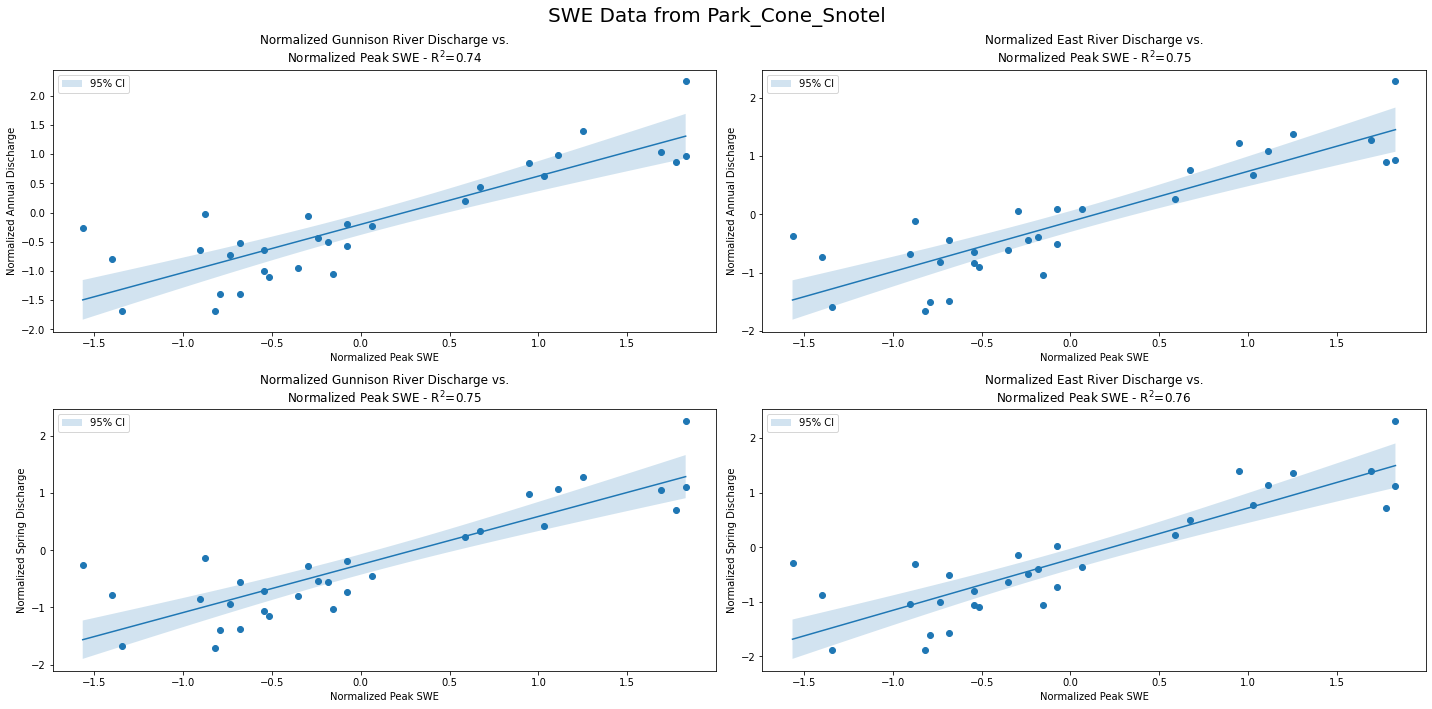

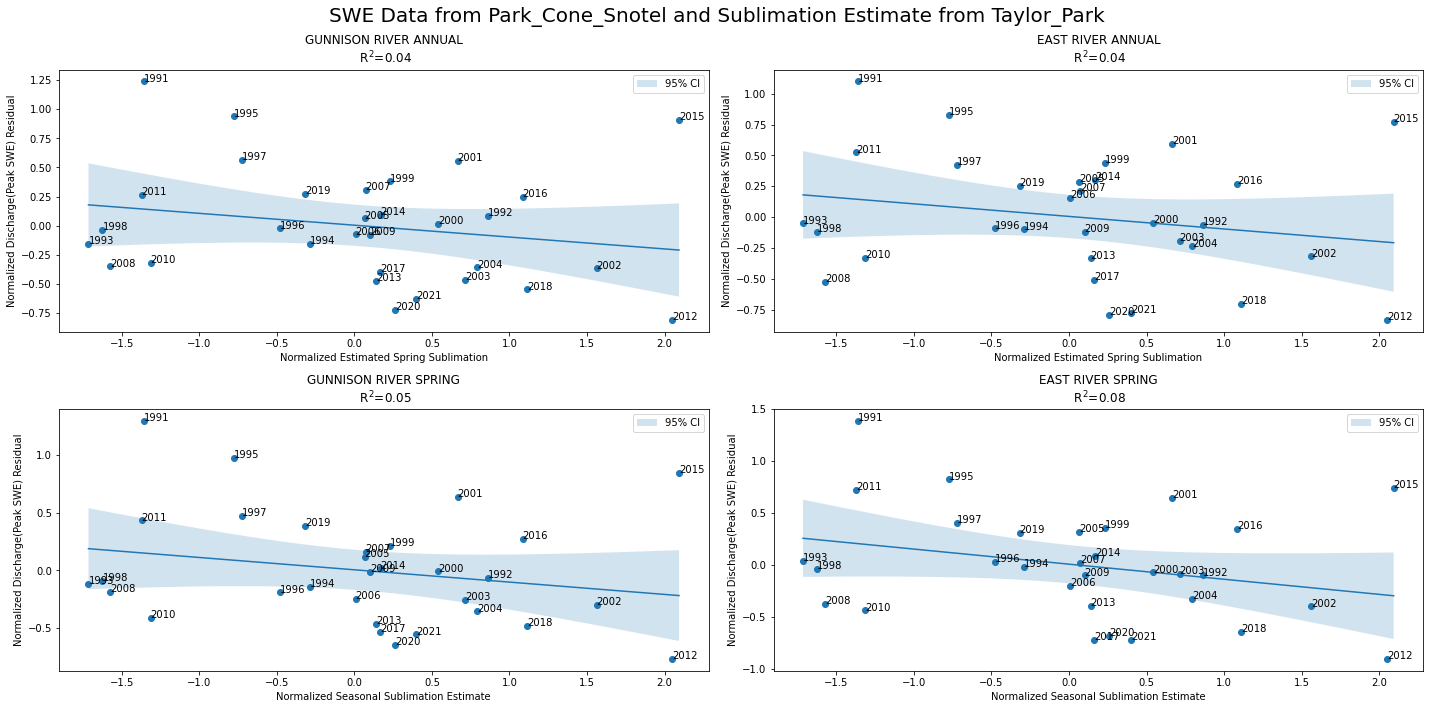

In [492]:
plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=sublimation_taylor_totals,
                                        peak_swe_vals=park_cone_max_swe_mm,
                                        start_year=1991,
                                        labels={'swe_source':'Park_Cone_Snotel',
                                                'sublimation_source':'Taylor_Park',
                                                'xlabel':'Normalized Seasonal Sublimation Estimate'})

### Results using Crested Butte snow course and Taylor Park Sublimation (1988-2021)

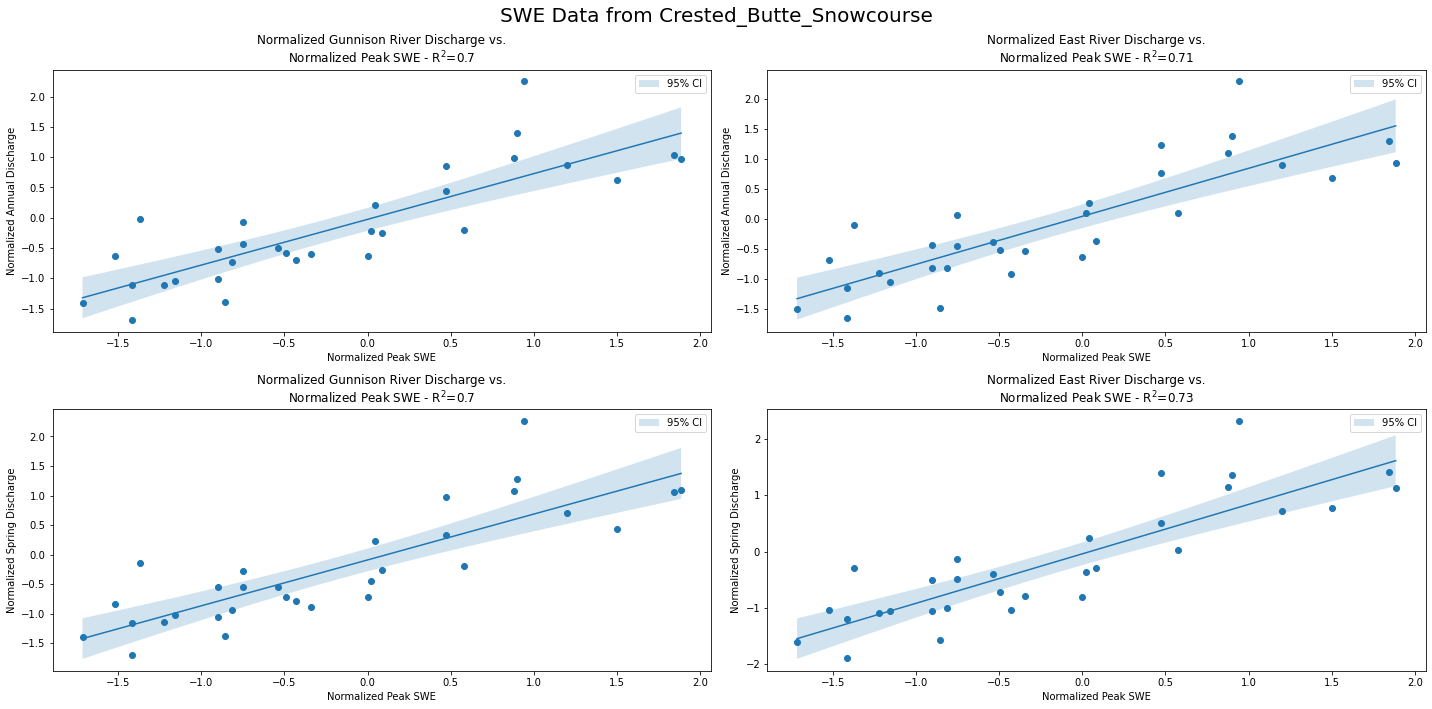

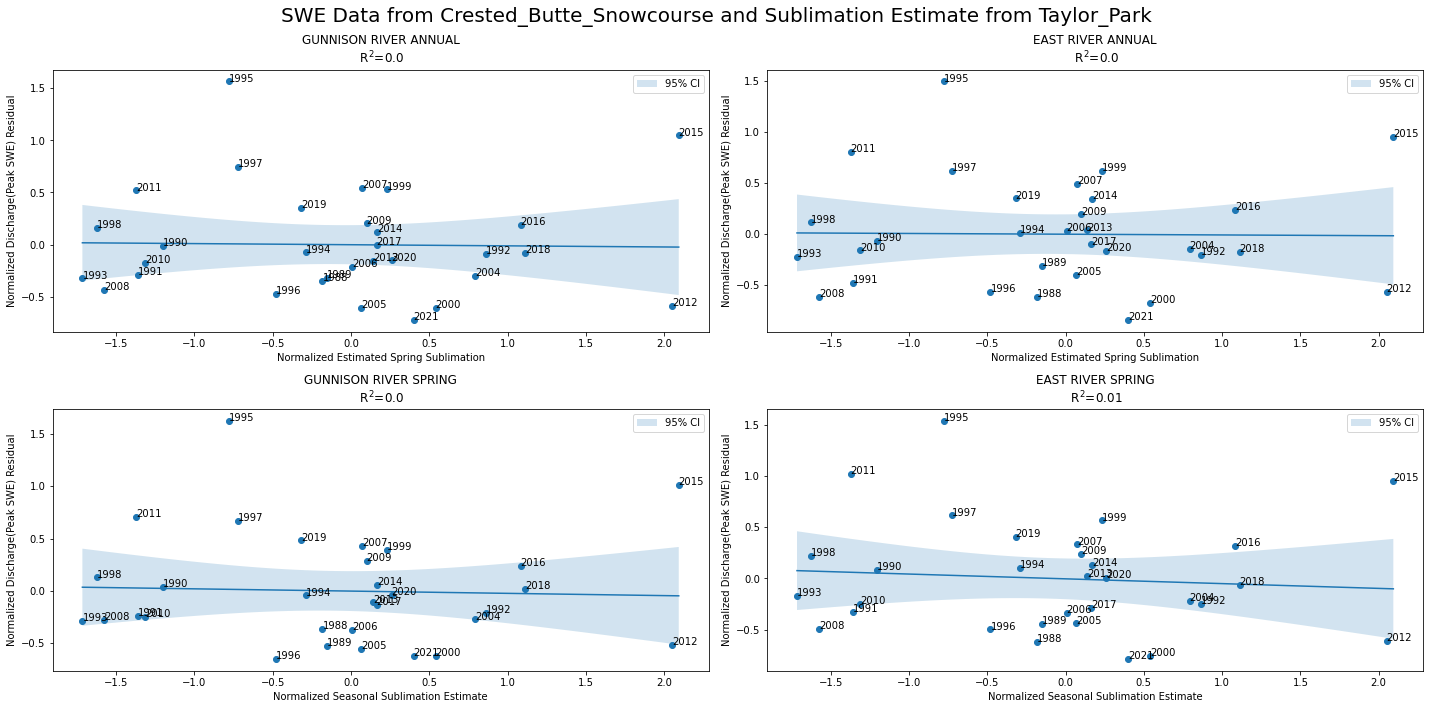

In [494]:
plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=sublimation_taylor_totals,
                                        peak_swe_vals=crested_butte_max_swe_mm,
                                        start_year=1988,
                                        labels={'swe_source':'Crested_Butte_Snowcourse',
                                                'sublimation_source':'Taylor_Park',
                                                'xlabel':'Normalized Seasonal Sublimation Estimate'})


### Results using Crested Butte snow course and Gunnison Sublimation (1997-2021)

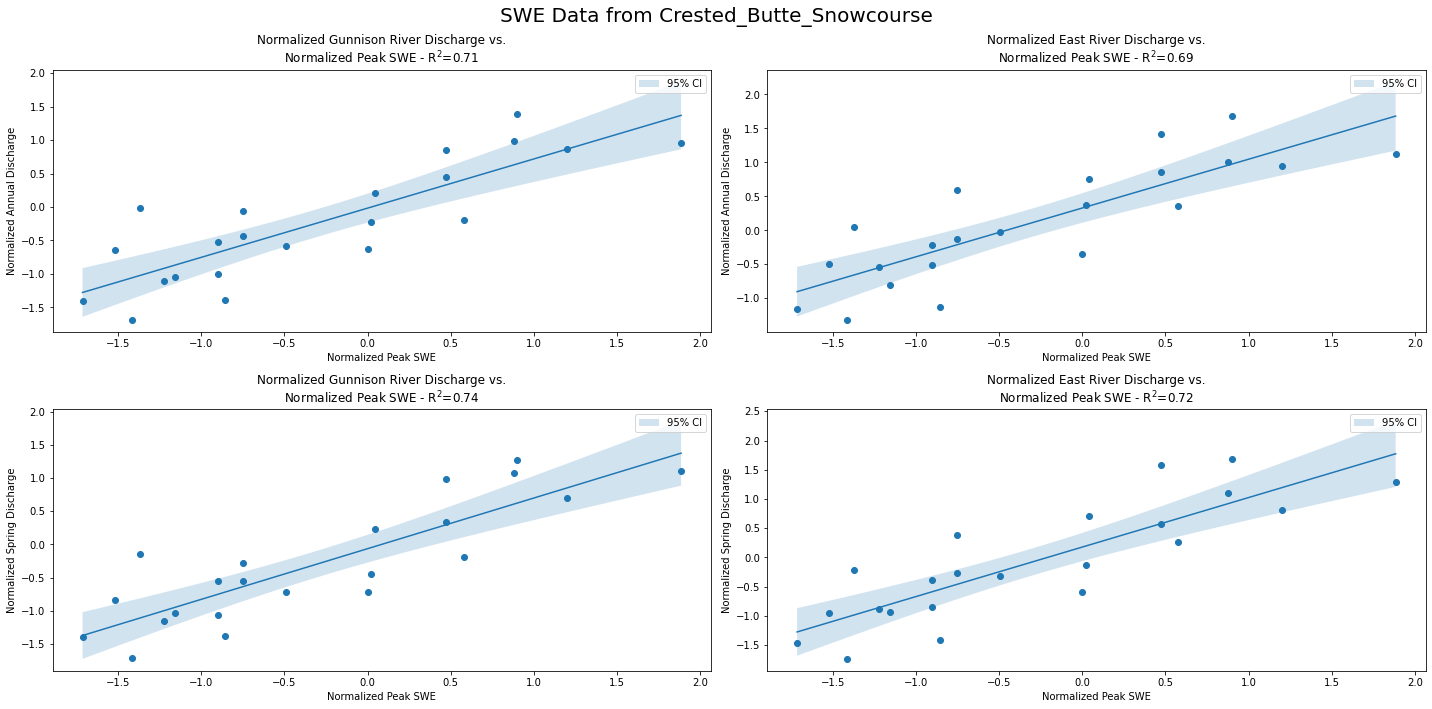

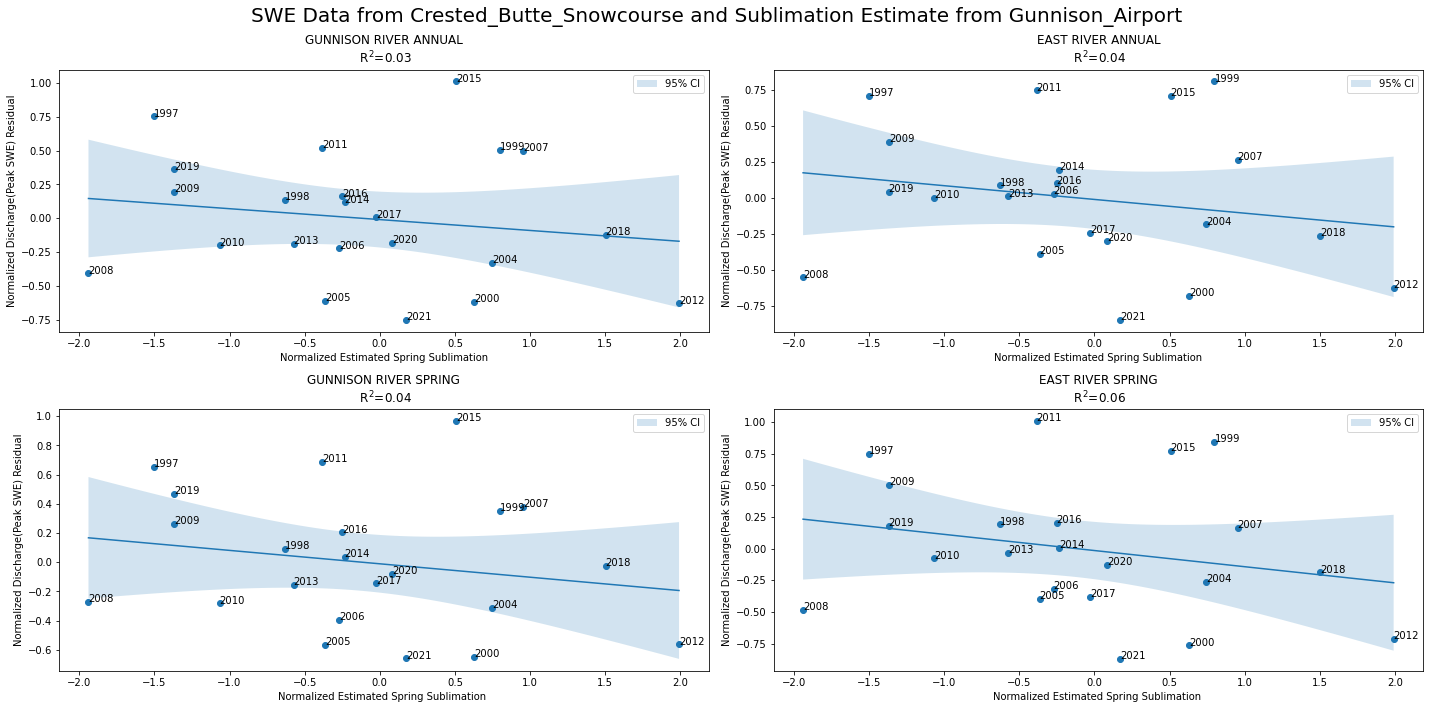

In [426]:
plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=sublimation_kguc_totals,
                                        peak_swe_vals=crested_butte_max_swe_mm,
                                        start_year=1997,
                                        labels={'swe_source':'Crested_Butte_Snowcourse',
                                                'sublimation_source':'Gunnison_Airport'})

(-2.5, 2.5)

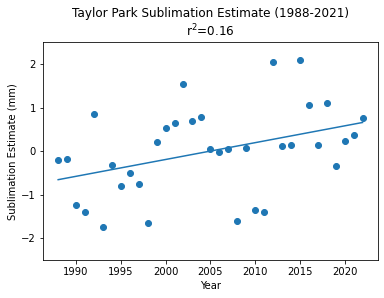

In [495]:
plt.scatter(sublimation_taylor_totals.index,normalize_data(sublimation_taylor_totals))

linregress_stats = stats.linregress(sublimation_taylor_totals.index,normalize_data(sublimation_taylor_totals))
plt.plot(sublimation_taylor_totals.index, linregress_stats[0]*sublimation_taylor_totals.index+linregress_stats[1])
plt.xlabel('Year')
plt.ylabel('Sublimation Estimate (mm)')
plt.title(f'Taylor Park Sublimation Estimate (1988-2021)\nr$^2$={round(linregress_stats[2]**2,2)}')
plt.ylim(-2.5,2.5)

### Running the same analysis using the billy barr dataset going back to 2016

In [ ]:
filepath = r"C:\Users\dlhogan\OneDrive - UW\Documents\Coursework\UW-21-22\Q2-spring-quarter-2022\mtn-hydro\Scripts\billy-barr-all.dat"
bb_data = pd.read_table(filepath, delimiter=',', header=1).dropna()
units = bb_data.loc[0].to_list()
bb_data = bb_data.loc[1:]
col_renames = [col.replace(' ','') for col in bb_data.columns]
bb_data = bb_data.rename(columns=dict(zip(bb_data.columns,col_renames)))

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_32944\2800660841.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  bb_data = pd.read_table(filepath, delimiter=',', header=1).dropna()


In [ ]:
bb_data['Datetime'] = pd.to_datetime(bb_data['Date']+' '+bb_data['Time'], format='%Y%m%d %H:%M')
bb_data = bb_data.set_index('Datetime')
bb_data_ma = bb_data[~bb_data.isin(['M',-9999.])]

In [ ]:
bb_daily_ma = bb_data_ma.groupby(bb_data_ma.index.date).mean()
bb_daily_ma.index = pd.to_datetime(bb_daily_ma.index)

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_32944\1785934240.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  bb_daily_ma = bb_data_ma.groupby(bb_data_ma.index.date).mean()


In [ ]:
# Calculated lw net and winterize the data
winter_bb_data = bb_daily_ma.loc[bb_daily_ma.index.month < 5 | ((bb_daily_ma.index.month == 12) & (bb_daily_ma.index.day > 1)) ]
net_bb_winter = calc_net_lw_radiation(temperature=(5/9)*(winter_bb_data['AvAir'].astype(float)-32), 
                      relative_humidity=winter_bb_data['Rel'].astype(float),
                      elevation=2890
                        )


In [ ]:
cols = []
count = 1
for column in winter_bb_data.columns:
    if column == 'Wind':
        cols.append(f'Wind_{count}')
        count+=1
        continue
    cols.append(column)
winter_bb_data.columns = cols

In [ ]:
sublimation_bb_pm = pyet.pm(tmean=(5/9)*(winter_bb_data['AvAir'].astype(float)-32),
        tmax=(winter_bb_data['MxAir'].astype(float)-32)*(5/9),
        tmin=(winter_bb_data['MnAir'].astype(float)-32)*(5/9),
        rhmax=winter_bb_data['MxRel'].astype(float),
        rhmin=winter_bb_data['MnRel'].astype(float),
        wind=winter_bb_data['Wind_1'].astype(float),
        rh=winter_bb_data['Rel'].astype(float),
        rn=net_bb_winter*3600*24/1e6 ,
        elevation=2890)
sublimation_bb_pm_df = sublimation_bb_pm.to_frame(name='sublimation_mm')
sublimation_bb_pm_df['water_year'] =  sublimation_bb_pm_df.index.year.where(sublimation_bb_pm_df.index.month < 10, sublimation_bb_pm_df.index.year + 1)
sublimation_bb_totals = sublimation_bb_pm_df['sublimation_mm'].groupby(sublimation_bb_pm_df['water_year']).sum()
sublimation_bb_totals.rename = 'sublimation'     


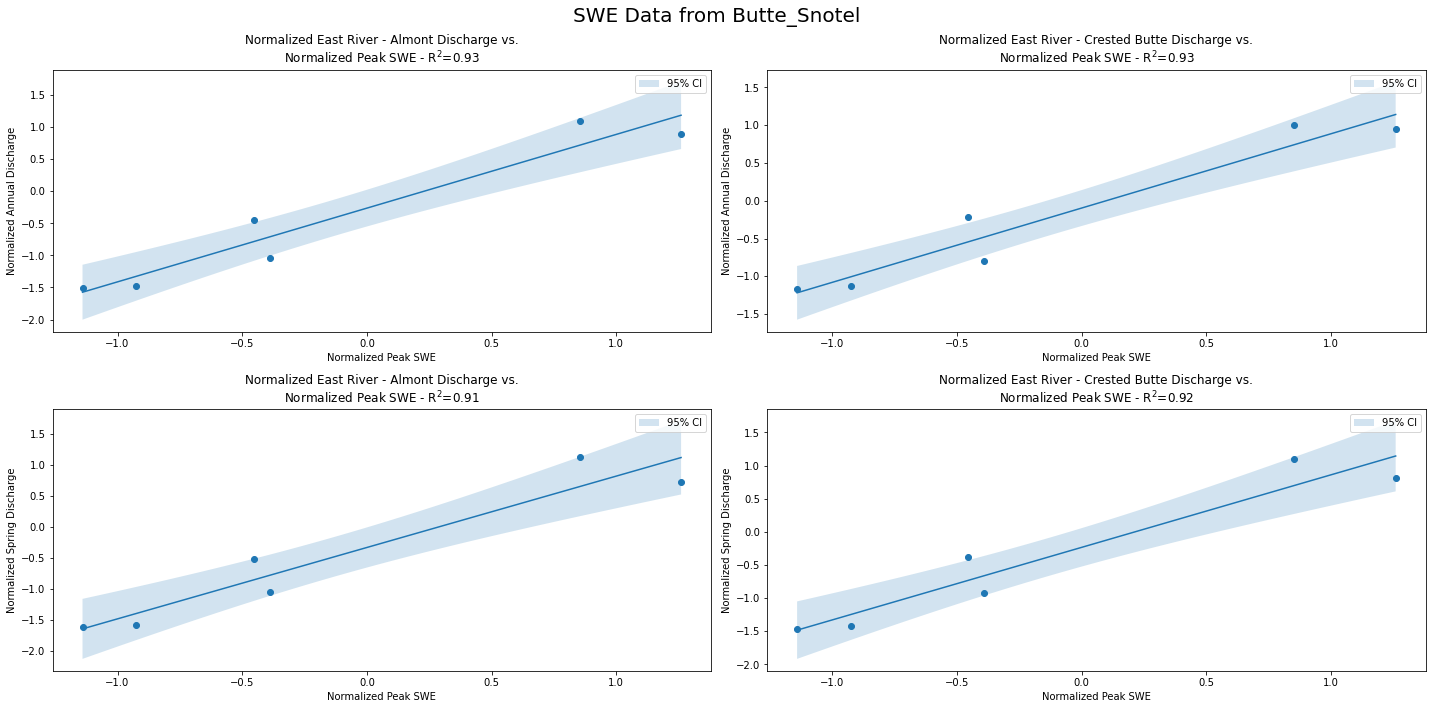

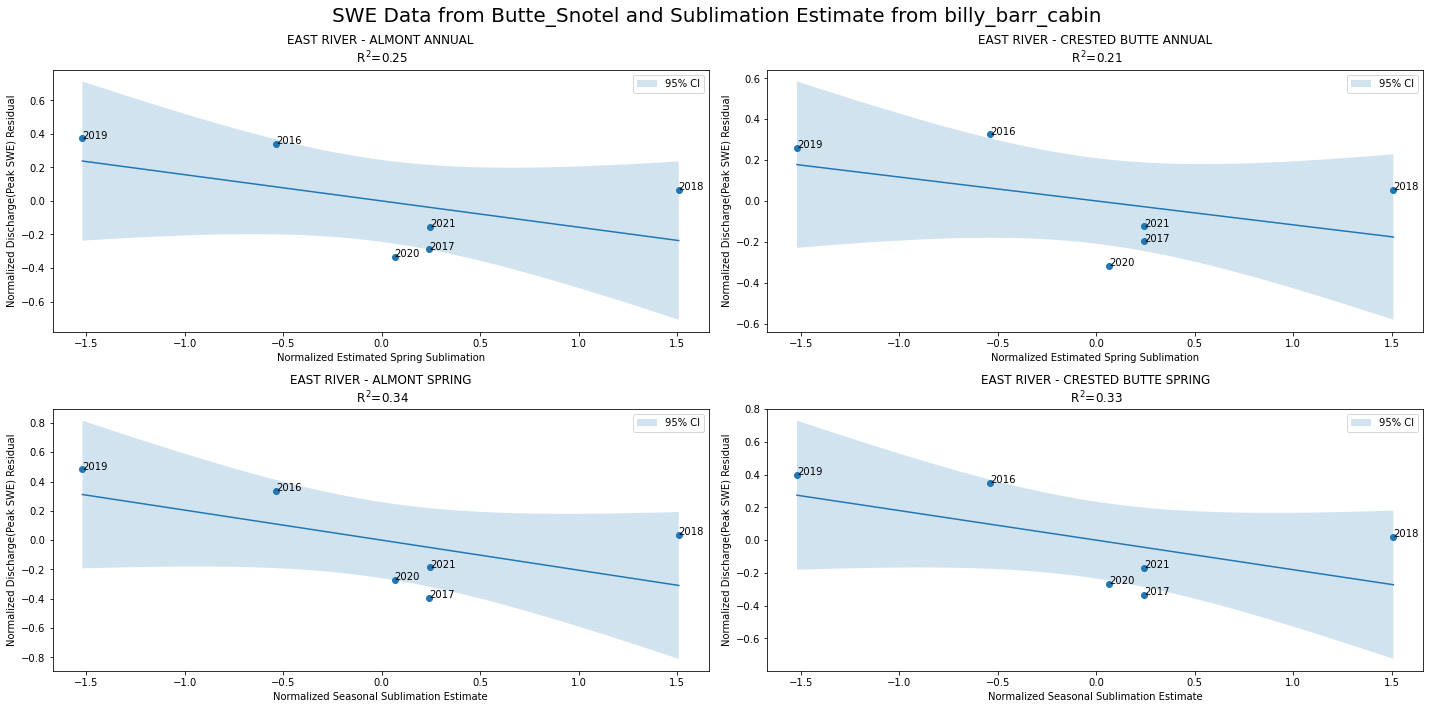

In [ ]:
sites = {'East River - Almont':'09112500', 'East River - Crested Butte':'09112200'}
plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=sublimation_bb_totals,
                                        peak_swe_vals=butte_max_swe_mm,
                                        start_year=2016,
                                        labels={'swe_source':'Butte_Snotel',
                                                'sublimation_source':'billy_barr_cabin',
                                                'xlabel':'Normalized Seasonal Sublimation Estimate'})


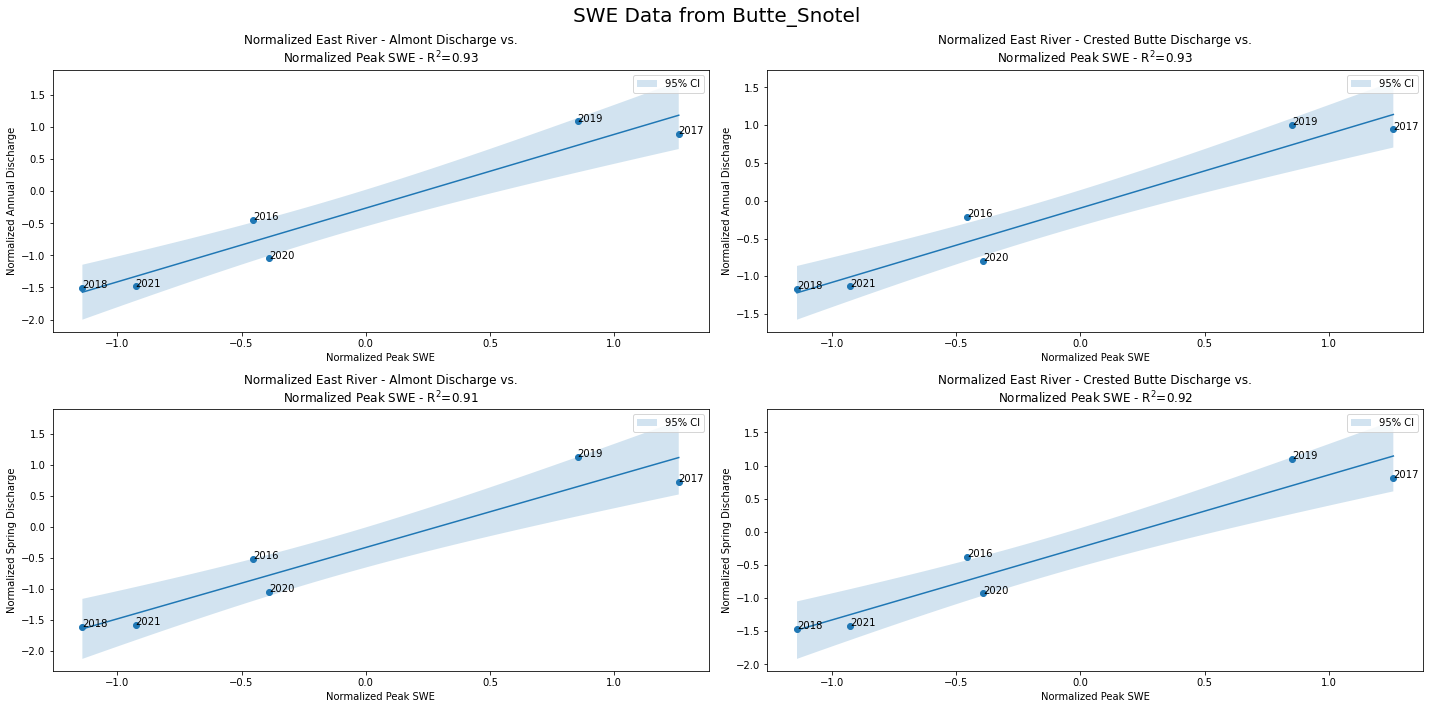

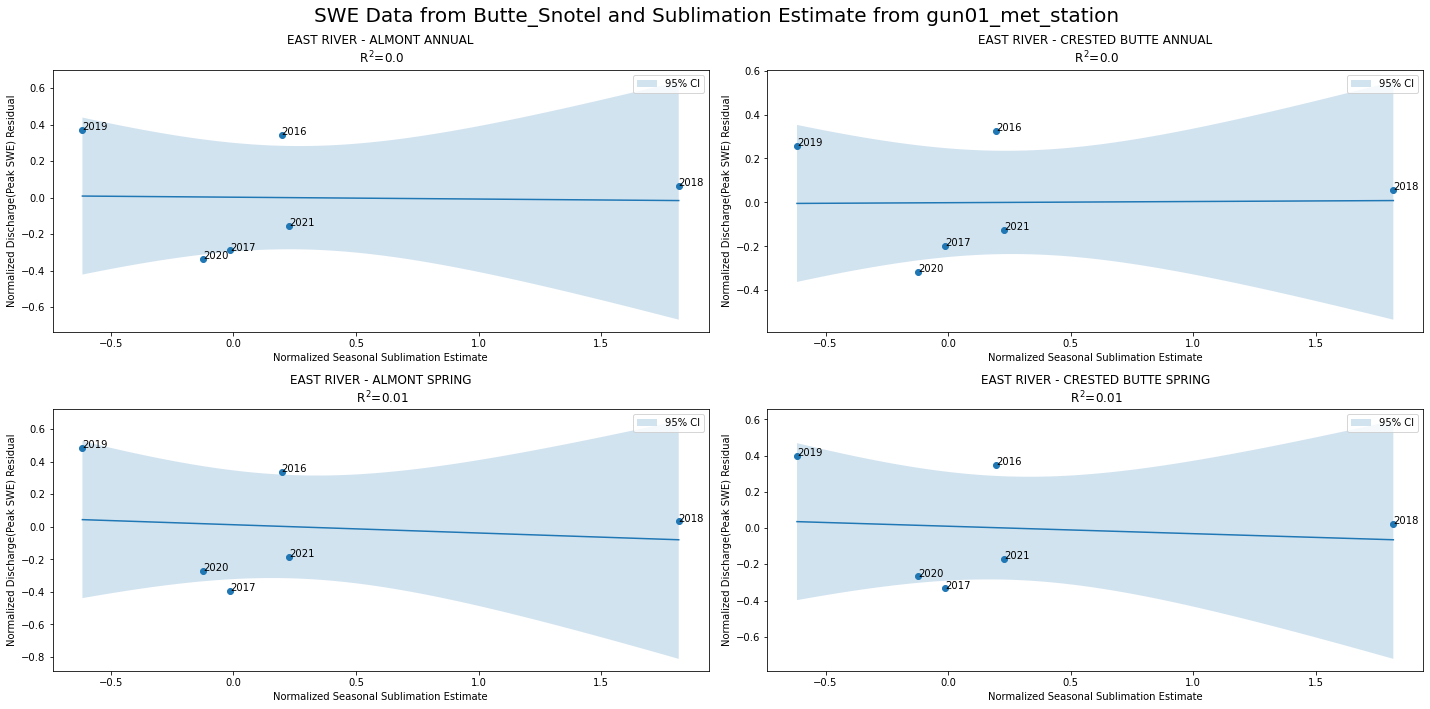

In [745]:
sites = {'East River - Almont':'09112500', 'East River - Crested Butte':'09112200'}
plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=normalize_data(winter_et_gun01),
                                        peak_swe_vals=butte_max_swe_mm,
                                        start_year=2016,
                                        labels={'swe_source':'Butte_Snotel',
                                                'sublimation_source':'gun01_met_station',
                                                'xlabel':'Normalized Seasonal Sublimation Estimate'})

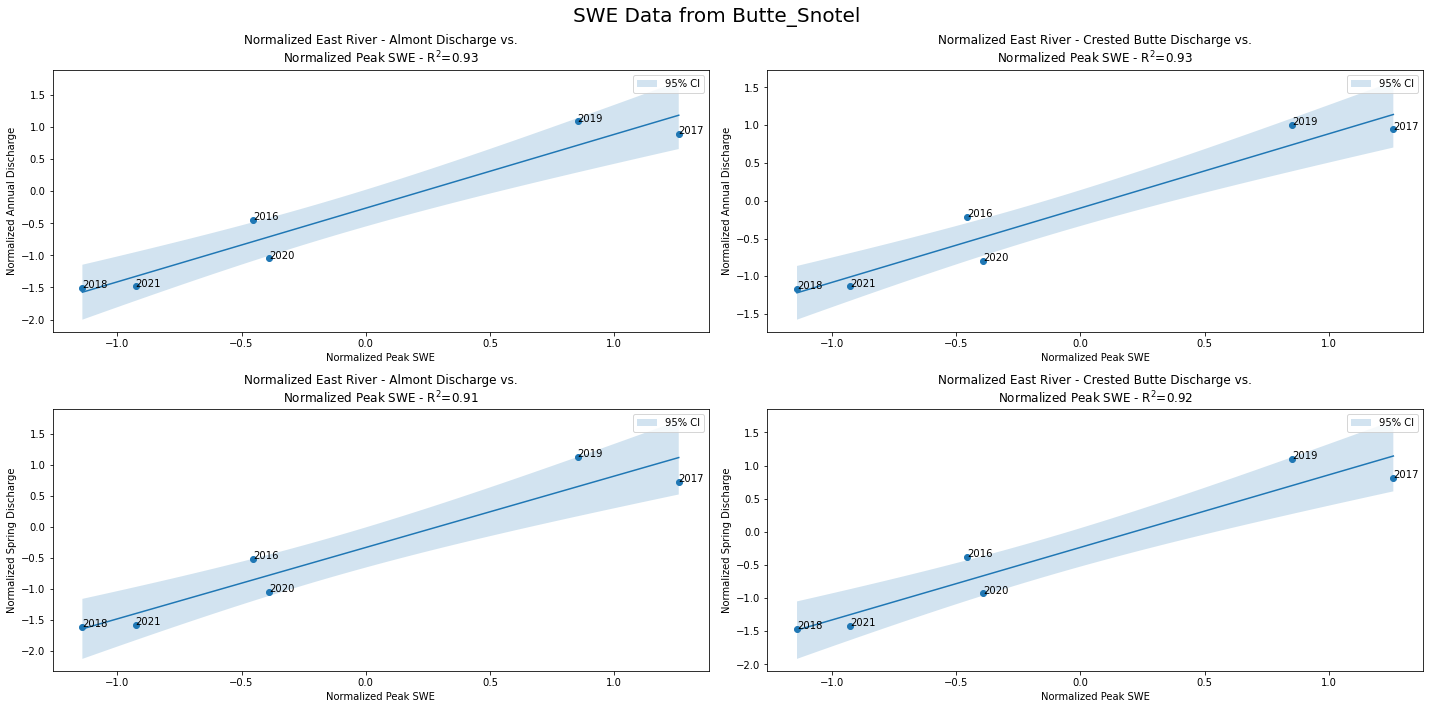

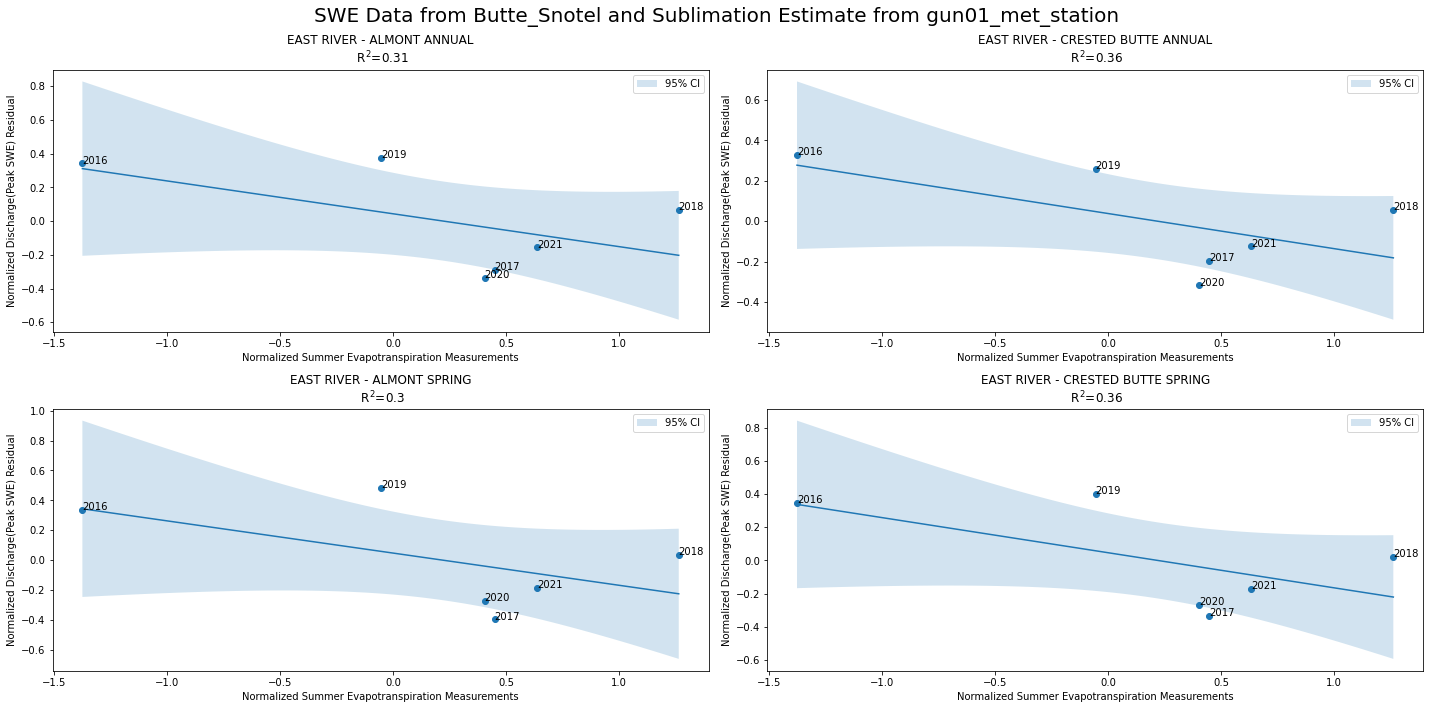

In [746]:
sites = {'East River - Almont':'09112500', 'East River - Crested Butte':'09112200'}
plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=normalize_data(summer_et_gun01),
                                        peak_swe_vals=butte_max_swe_mm,
                                        start_year=2016,
                                        labels={'swe_source':'Butte_Snotel',
                                                'sublimation_source':'gun01_met_station',
                                                'xlabel':'Normalized Summer Evapotranspiration Measurements'})

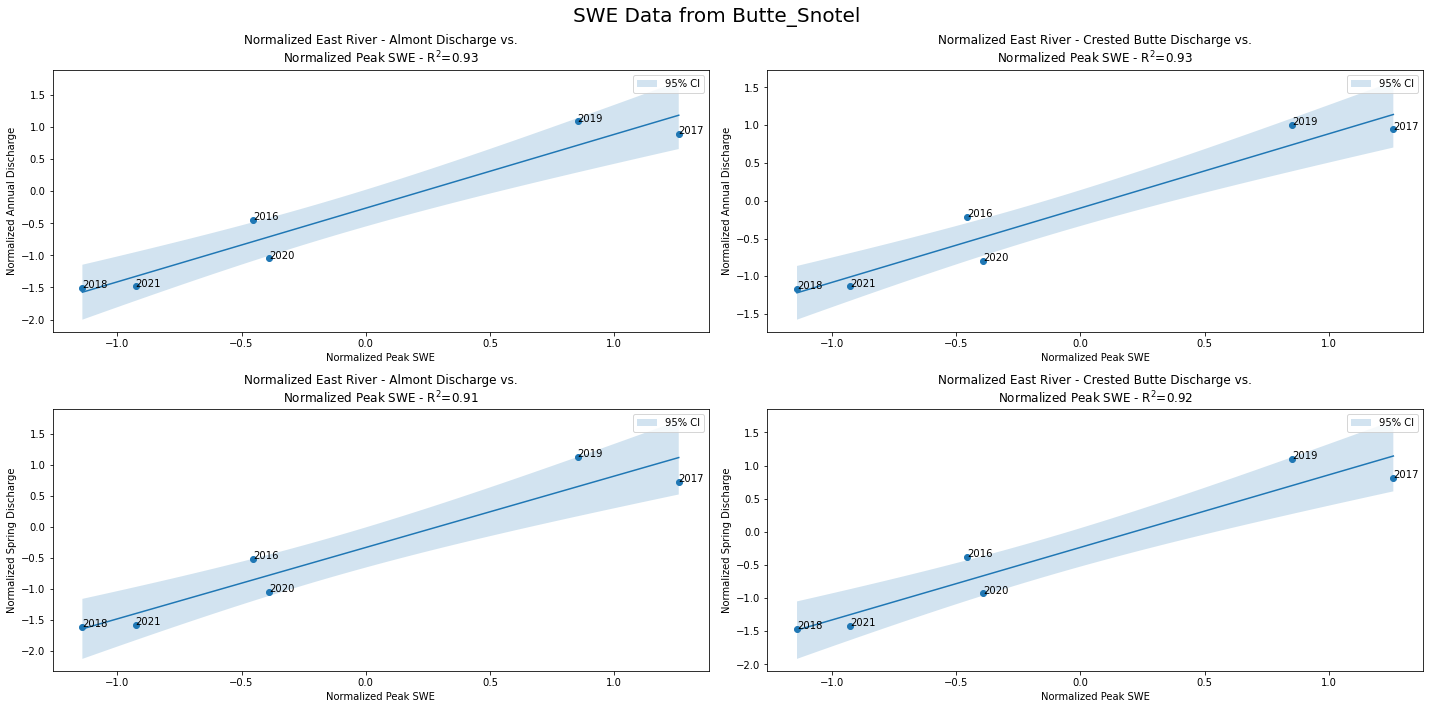

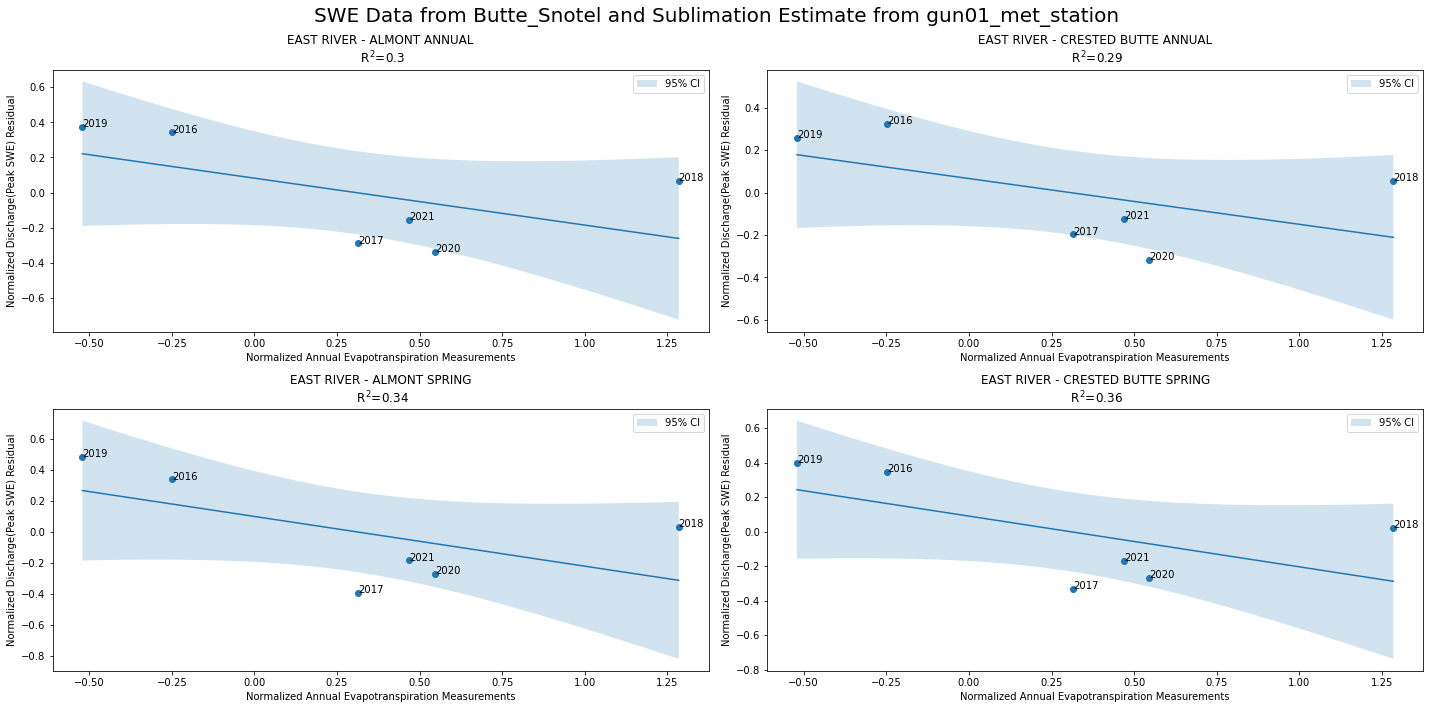

In [744]:
sites = {'East River - Almont':'09112500', 'East River - Crested Butte':'09112200'}
plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=normalize_data(et_gun01),
                                        peak_swe_vals=butte_max_swe_mm,
                                        start_year=2016,
                                        labels={'swe_source':'Butte_Snotel',
                                                'sublimation_source':'gun01_met_station',
                                                'xlabel':'Normalized Annual Evapotranspiration Measurements'})

## Here I look into a couple different parameters that may account for more variability in accounting for the snow water gap

### Current years' precipitation anomaly

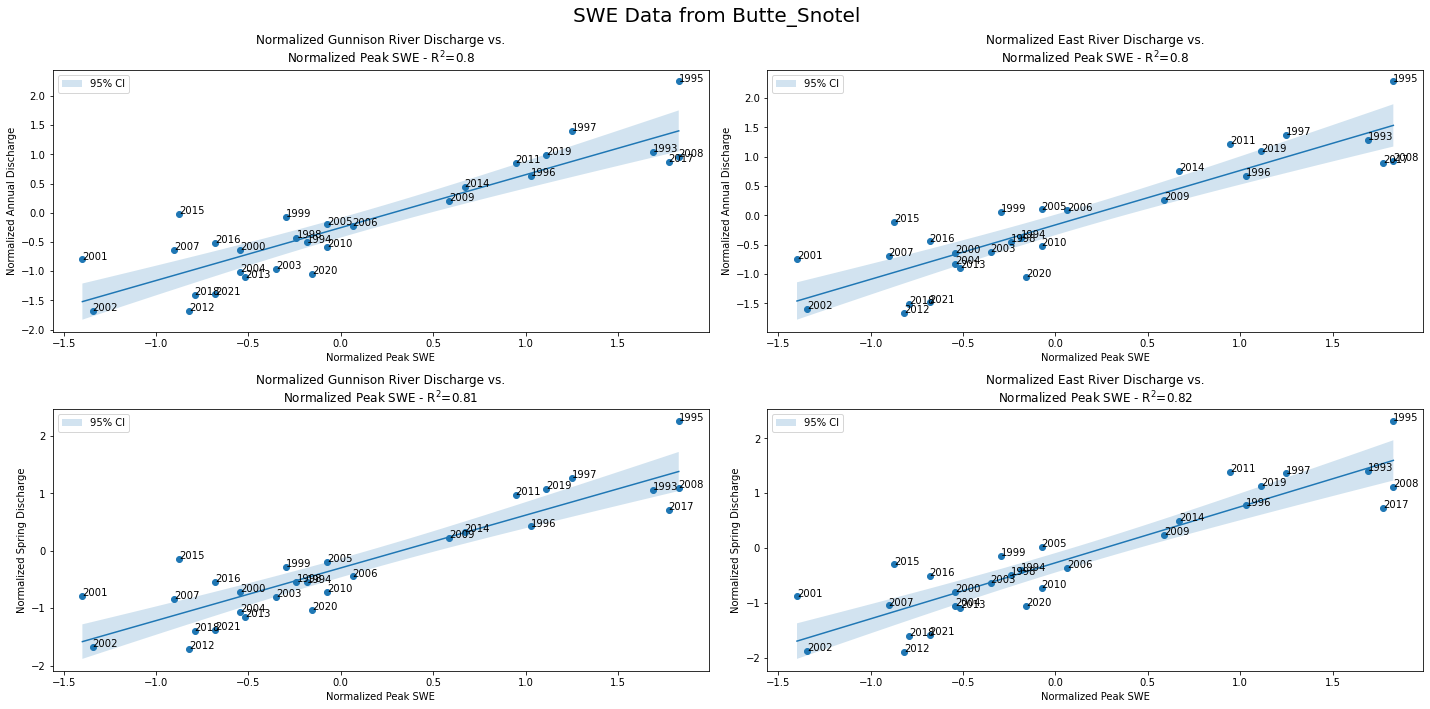

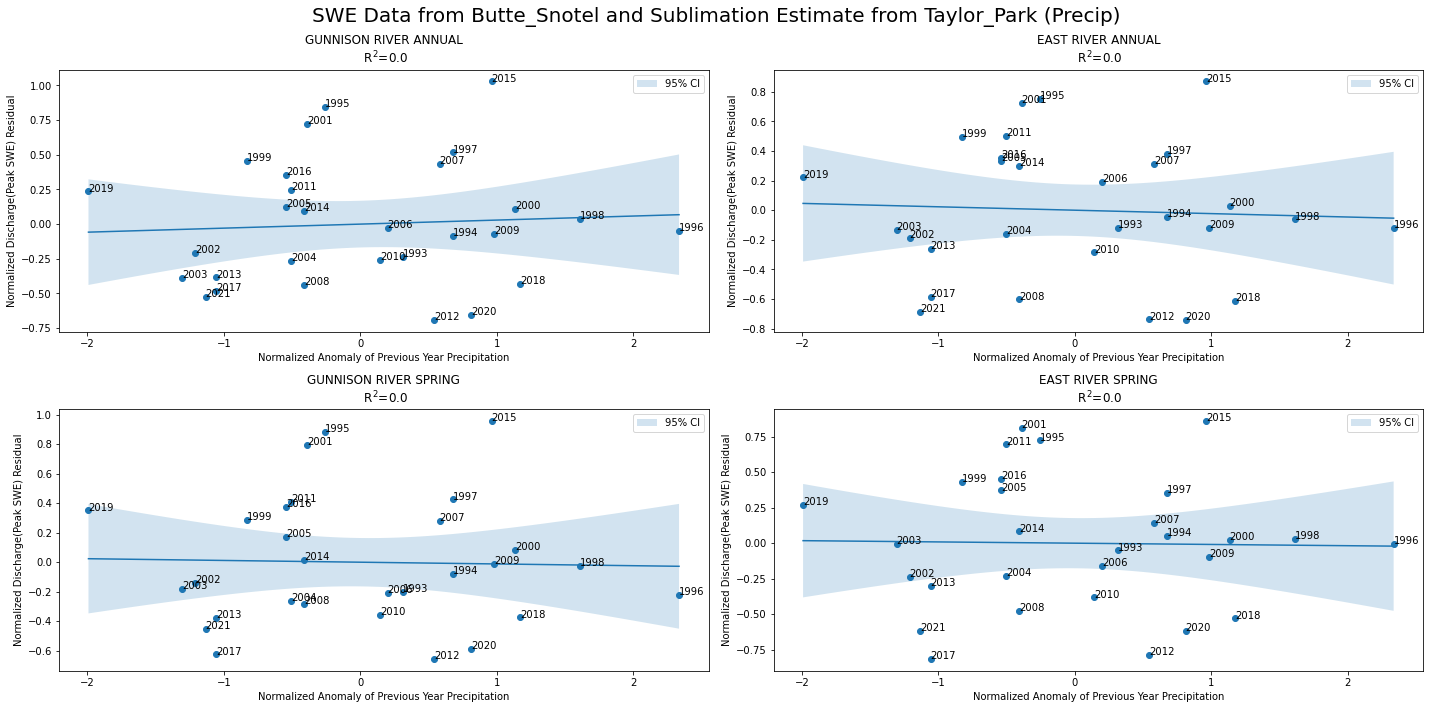

In [ ]:
annual_precip = park_cone_df['PRECIPITATON'].groupby(park_cone_df['water_year']).sum()
annual_precip_norm_anom =  normalize_data(annual_precip)

plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=annual_precip_norm_anom,
                                        peak_swe_vals=park_cone_max_swe_mm,
                                        start_year=1992,
                                        labels={'swe_source':'Butte_Snotel',
                                                'sublimation_source':'Taylor_Park (Precip)',
                                                'xlabel':'Normalized Anomaly of Previous Year Precipitation'})

### Previous Summer/Fall Precipitation Anomaly

In [ ]:
non_snow_precip = park_cone_df.loc[(park_cone_df.index.month>6) | (park_cone_df.index.month<10)]
annual_precip = non_snow_precip['PRECIPITATON'].groupby(non_snow_precip['water_year']).sum()
annual_precip_norm_anom = normalize_data(annual_precip)
annual_precip_norm_anom.index = annual_precip_norm_anom.index+1

plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=annual_precip_norm_anom,
                                        peak_swe_vals=park_cone_max_swe_mm,
                                        start_year=1993,
                                        labels={'swe_source':'Butte_Snotel',
                                                'sublimation_source':'Taylor_Park (Precip)',
                                                'xlabel':'Normalized Anomaly of Previous Year Precipitation'})

### Previous 2-year average anomaly of precipitation

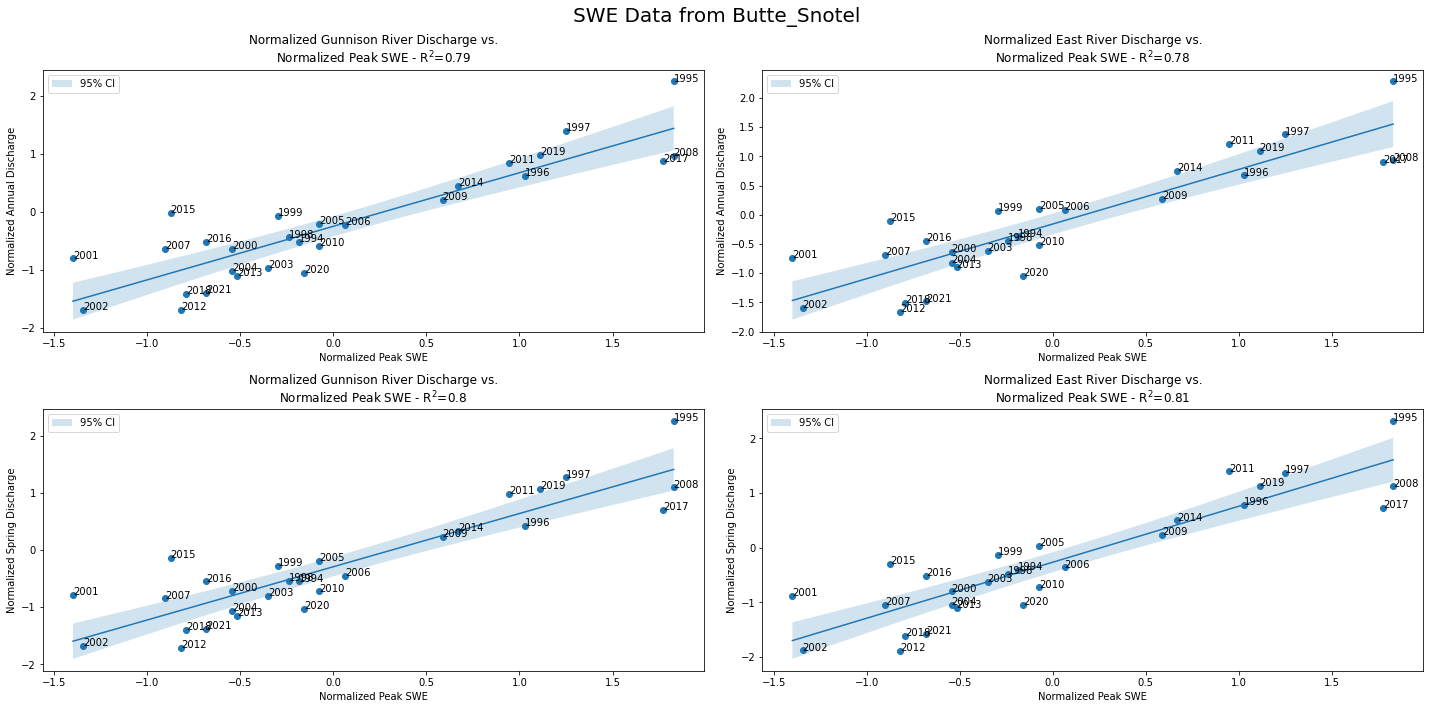

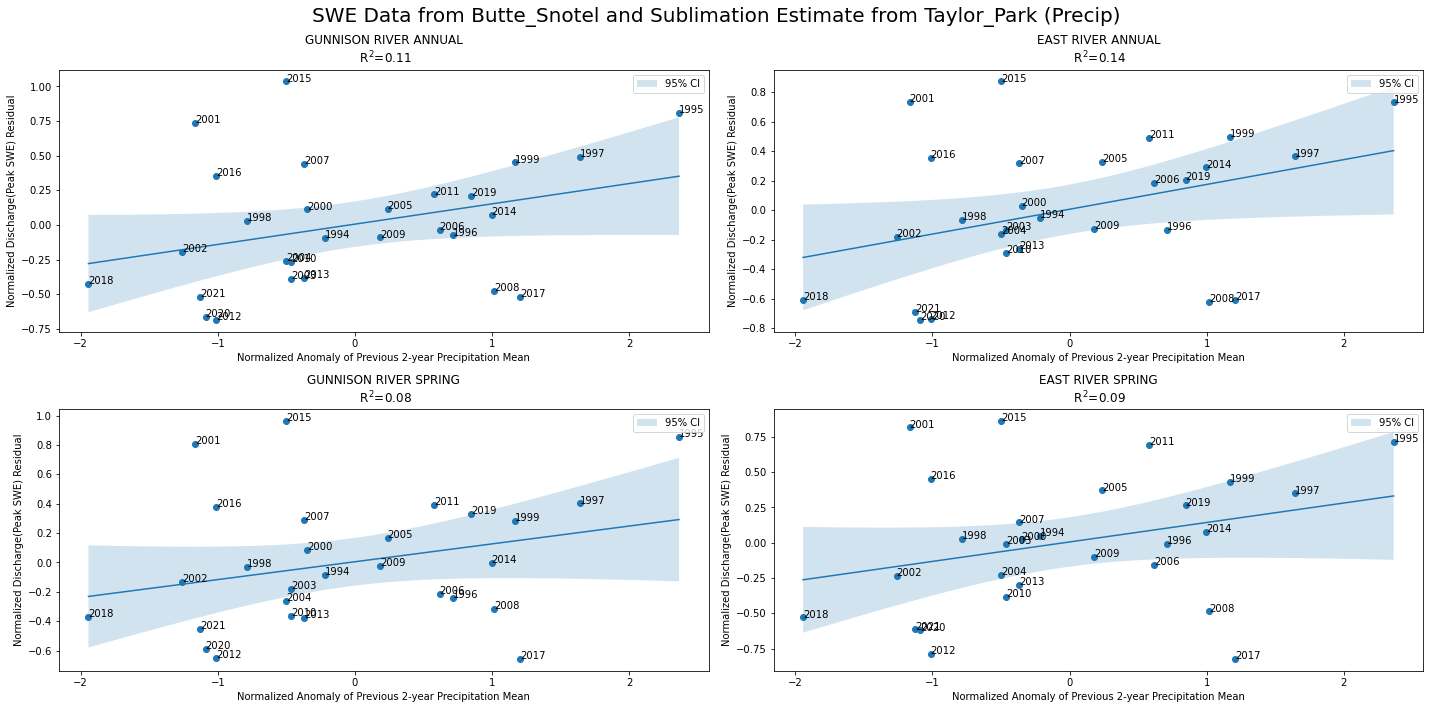

In [ ]:
tmp = []
yr = []
for i,val in enumerate(annual_precip_norm_anom):
    if i < len(annual_precip_norm_anom)-1:
        tmp.append(np.mean([val,annual_precip_norm_anom.iloc[i+1]]))
        yr.append(annual_precip_norm_anom.index[i]+2)

previous_2yr_anomaly = pd.Series(data=tmp,index=yr)

plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=previous_2yr_anomaly,
                                        peak_swe_vals=park_cone_max_swe_mm,
                                        start_year=1994,
                                        labels={'swe_source':'Butte_Snotel',
                                                'sublimation_source':'Taylor_Park (Precip)',
                                                'xlabel':'Normalized Anomaly of Previous 2-year Precipitation Mean'})

### Previous 3-years precipiation anomaly

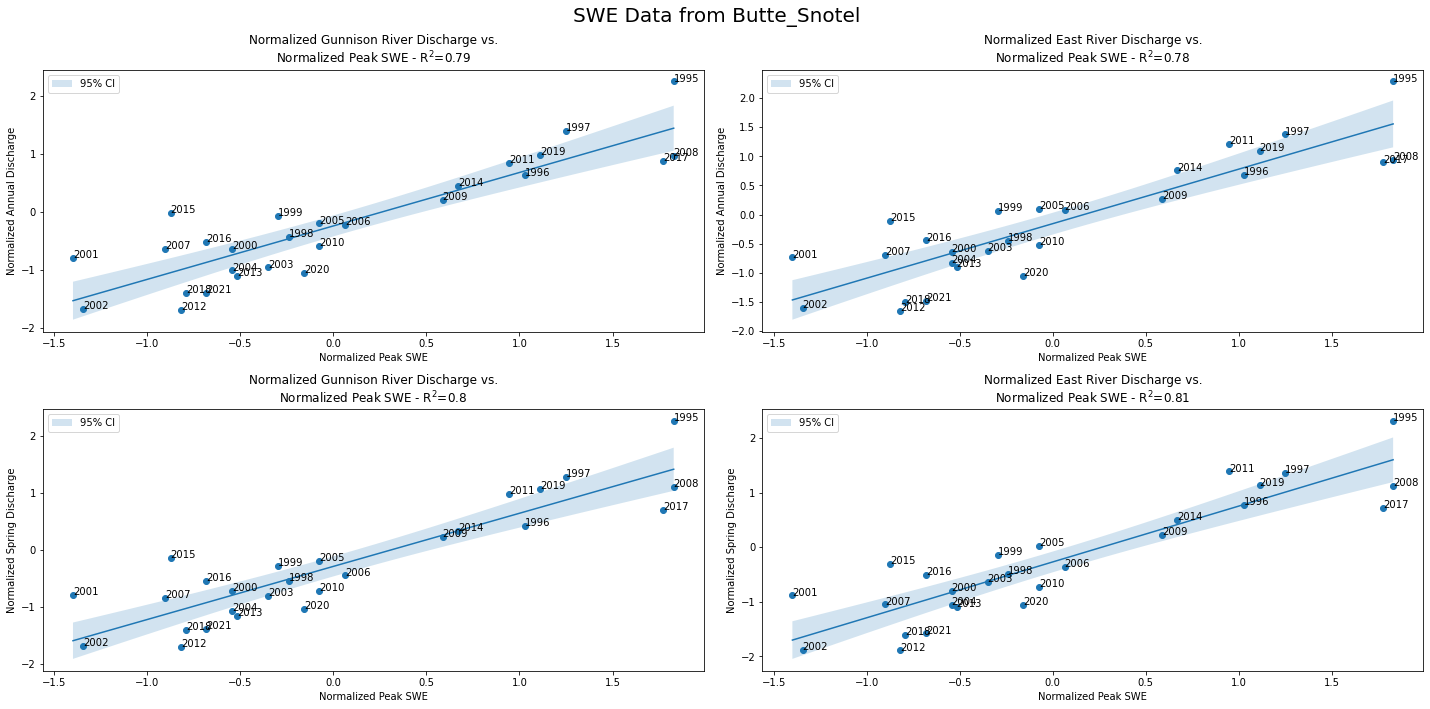

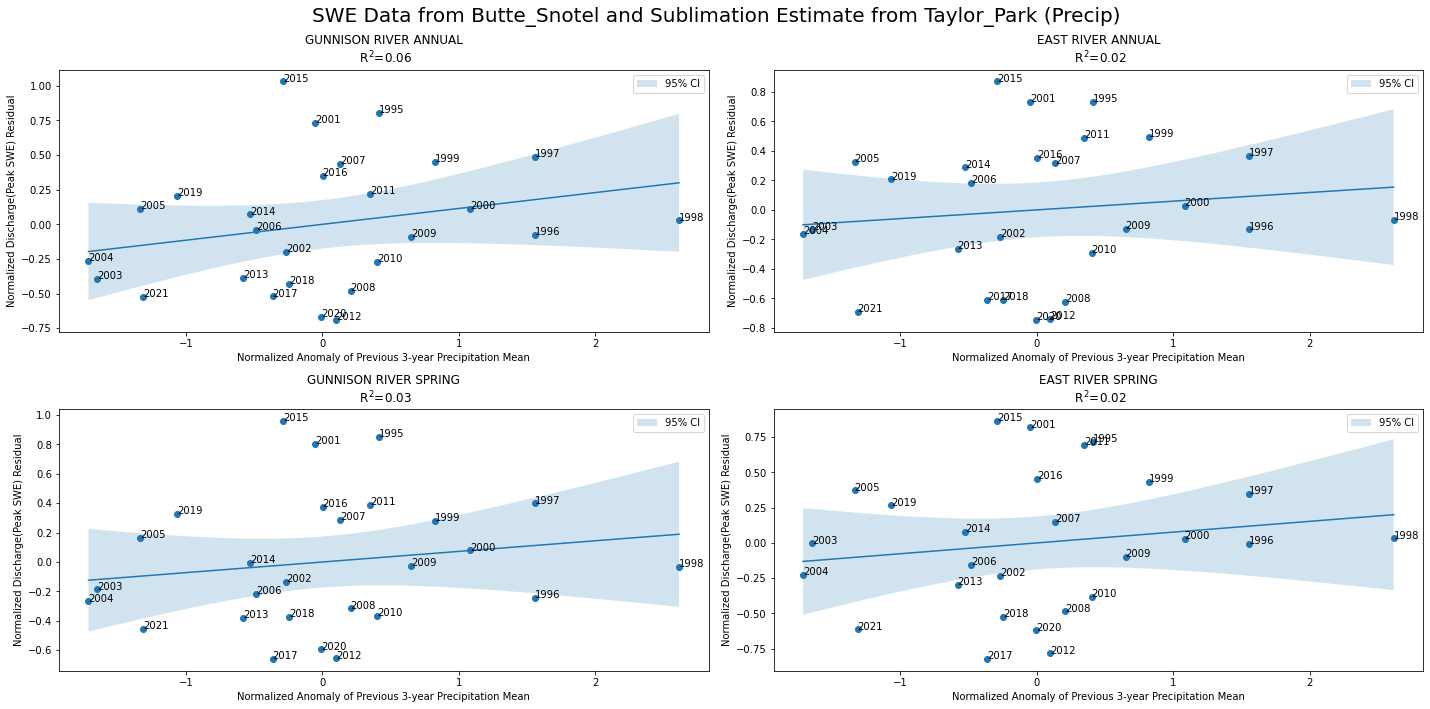

In [ ]:
tmp = []
yr = []
for i,val in enumerate(annual_precip_norm_anom):
    if i < len(annual_precip_norm_anom)-2:
        tmp.append(np.mean([val,annual_precip_norm_anom.iloc[i+1],annual_precip_norm_anom.iloc[i+2]]))
        yr.append(annual_precip_norm_anom.index[i]+3)

previous_3yr_anomaly = pd.Series(data=tmp,index=yr)

plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=previous_3yr_anomaly,
                                        peak_swe_vals=park_cone_max_swe_mm,
                                        start_year=1995,
                                        labels={'swe_source':'Butte_Snotel',
                                                'sublimation_source':'Taylor_Park (Precip)',
                                                'xlabel':'Normalized Anomaly of Previous 3-year Precipitation Mean'})

# Next I'll look into a couple of different reanalysis datasets 

## Get NCEP reanalysis data

In [402]:
# coords = (38.95615768432617, -106.98785400390625)
coords = (37.5,-107.5)
product_codes = ['air','rhum', 'uwnd','vwnd']

In [403]:
def ncep_reanalysis_dynamic_load(product, product_code, start_year, end_year, coords, first_yr_start_date=None, first_yr_end_date=None):
    
    # Connect to FTP server
    print('Connecting to FTP server...')
    ftp = ftplib.FTP('ftp2.psl.noaa.gov') # Connect to NOAA's FTP
    ftp.login() # Anonymous login

    ftp.cwd(f'./Datasets/ncep.reanalysis.dailyavgs/{product}/')

    # Collect files into list
    print('Connected and pulled files...')
    files = ftp.nlst()
    ftp.close()
    print('Closed FTP session...')

    # Separate out files that I'm interested in
    product_files = []
    years = np.arange(start_year, end_year+1,1).astype(str)
    
    for file in files:
        if (product_code in file) & (file[-7:-3] in years):
            product_files.append(file)

    datasets = []
    # Concatenate on year and filter out unncessary values if desired
    for file in product_files:
        print(f'Fetching {file}...')
        # used this as reference: https://towardsdatascience.com/an-efficient-way-to-read-data-from-the-web-directly-into-python-a526a0b4f4cb
        url = f'ftp://ftp2.psl.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/{product}/' + file
        req = urllib.request.Request(url)

        with urllib.request.urlopen(req) as resp:
            ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
            
            print(f'Filtering {file}...')
            # Transform coordiantes
            ds.coords['lon'] = ds.coords['lon'] - 180
            # Filter to western US
            ds = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
            
            # If provided, remove start year's dates
            if (first_yr_start_date) and (first_yr_end_date) and (f'{start_year}' in file):
                ds = ds.sel(time=slice(first_yr_start_date, first_yr_end_date))
            
            datasets.append(ds)
            print('Done!')
    return xr.concat(datasets, dim='time')

In [404]:
product_codes = ['air','rhum', 'uwnd','vwnd']
for i,code in enumerate(product_codes):
    if i == 0:
        ncep_ds = ncep_reanalysis_dynamic_load('surface', code, 1948, 2021, coords, first_yr_start_date=None, first_yr_end_date=None)
    else:
        tmp = ncep_reanalysis_dynamic_load('surface', code, 1948, 2021, coords, first_yr_start_date=None, first_yr_end_date=None)
        ncep_ds = xr.merge([ncep_ds,tmp])

Connecting to FTP server...
Connected and pulled files...
Closed FTP session...
Fetching air.sig995.1948.nc...
Filtering air.sig995.1948.nc...
Done!
Fetching air.sig995.1949.nc...
Filtering air.sig995.1949.nc...
Done!
Fetching air.sig995.1950.nc...
Filtering air.sig995.1950.nc...
Done!
Fetching air.sig995.1951.nc...
Filtering air.sig995.1951.nc...
Done!
Fetching air.sig995.1952.nc...
Filtering air.sig995.1952.nc...
Done!
Fetching air.sig995.1953.nc...
Filtering air.sig995.1953.nc...
Done!
Fetching air.sig995.1954.nc...
Filtering air.sig995.1954.nc...
Done!
Fetching air.sig995.1955.nc...
Filtering air.sig995.1955.nc...
Done!
Fetching air.sig995.1956.nc...
Filtering air.sig995.1956.nc...
Done!
Fetching air.sig995.1957.nc...
Filtering air.sig995.1957.nc...
Done!
Fetching air.sig995.1958.nc...
Filtering air.sig995.1958.nc...
Done!
Fetching air.sig995.1959.nc...
Filtering air.sig995.1959.nc...
Done!
Fetching air.sig995.1960.nc...
Filtering air.sig995.1960.nc...
Done!
Fetching air.sig995.196

In [409]:
ncep_ds['wspd'] = np.sqrt(ncep_ds.uwnd**2 + ncep_ds.vwnd**2)

In [410]:
ncep_daily_ds = ncep_ds.to_pandas().groupby(ncep_ds.to_pandas().index.date).mean()
ncep_daily_ds.index = pd.to_datetime(ncep_daily_ds.index)

winter_ncep_ds = ncep_daily_ds.loc[(ncep_daily_ds.index.month<5) | (ncep_daily_ds.index.month==12)]
winter_ncep_ds

,lat,lon,air,rhum,uwnd,vwnd,wspd
1948-01-01,37.5,-107.5,255.489990,66.000000,1.470001,6.369995,6.537411
1948-01-02,37.5,-107.5,256.670013,58.000000,0.500000,4.150009,4.180021
1948-01-03,37.5,-107.5,253.570007,23.750000,-2.619995,2.820007,3.849262
1948-01-04,37.5,-107.5,251.369995,31.250000,-1.300003,4.740005,4.915044
1948-01-05,37.5,-107.5,256.970001,73.740005,5.050003,6.119995,7.934536
...,...,...,...,...,...,...,...
2021-12-27,37.5,-107.5,256.649994,28.750000,1.400001,0.550001,1.504162
2021-12-28,37.5,-107.5,253.849991,20.500000,-1.525000,2.200001,2.676870
2021-12-29,37.5,-107.5,251.199982,0.000000,-5.474999,4.475001,7.071157
2021-12-30,37.5,-107.5,254.749969,35.000000,-2.500000,5.525001,6.064291


In [411]:
net_ncep_winter = calc_net_lw_radiation(temperature=winter_ncep_ds['air']-267.65, 
                      relative_humidity=winter_ncep_ds['rhum'],
                      elevation=2890
                        )

c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\metpy\calc\thermo.py:1114: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\metpy\calc\thermo.py:1115: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)


In [412]:
sublimation_ncep_pm = pyet.pm(tmean=winter_ncep_ds['air']-265.15,
        wind=winter_ncep_ds['wspd'],
        rh=winter_ncep_ds['rhum'],
        rn=net_ncep_winter*3600*24/1e6 ,
        elevation=2890)
sublimation_ncep_pm_df = sublimation_ncep_pm.to_frame(name='sublimation_mm')
sublimation_ncep_pm_df['water_year'] =  sublimation_ncep_pm_df.index.year.where(sublimation_ncep_pm_df.index.month < 10, sublimation_ncep_pm_df.index.year + 1)
sublimation_ncep_totals = sublimation_ncep_pm_df['sublimation_mm'].groupby(sublimation_ncep_pm_df['water_year']).sum()
sublimation_ncep_totals.rename = 'sublimation'  

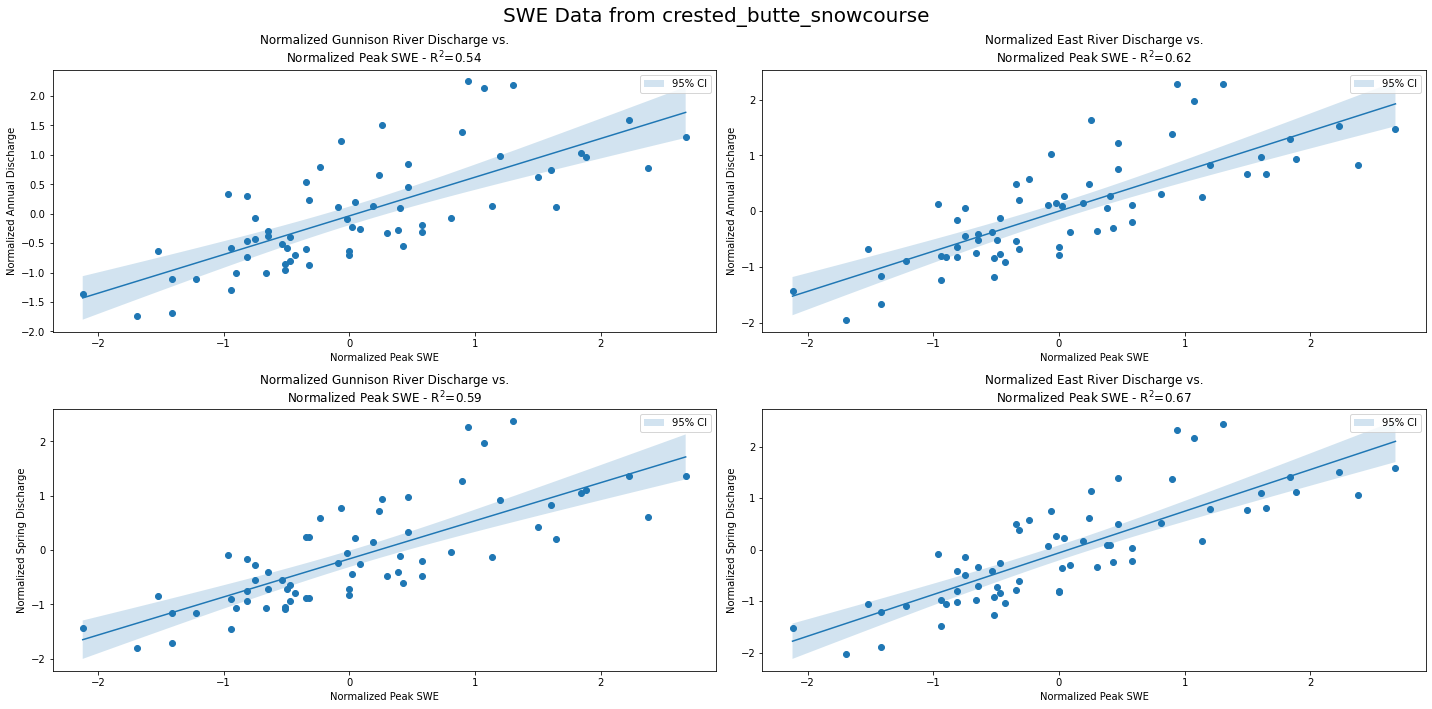

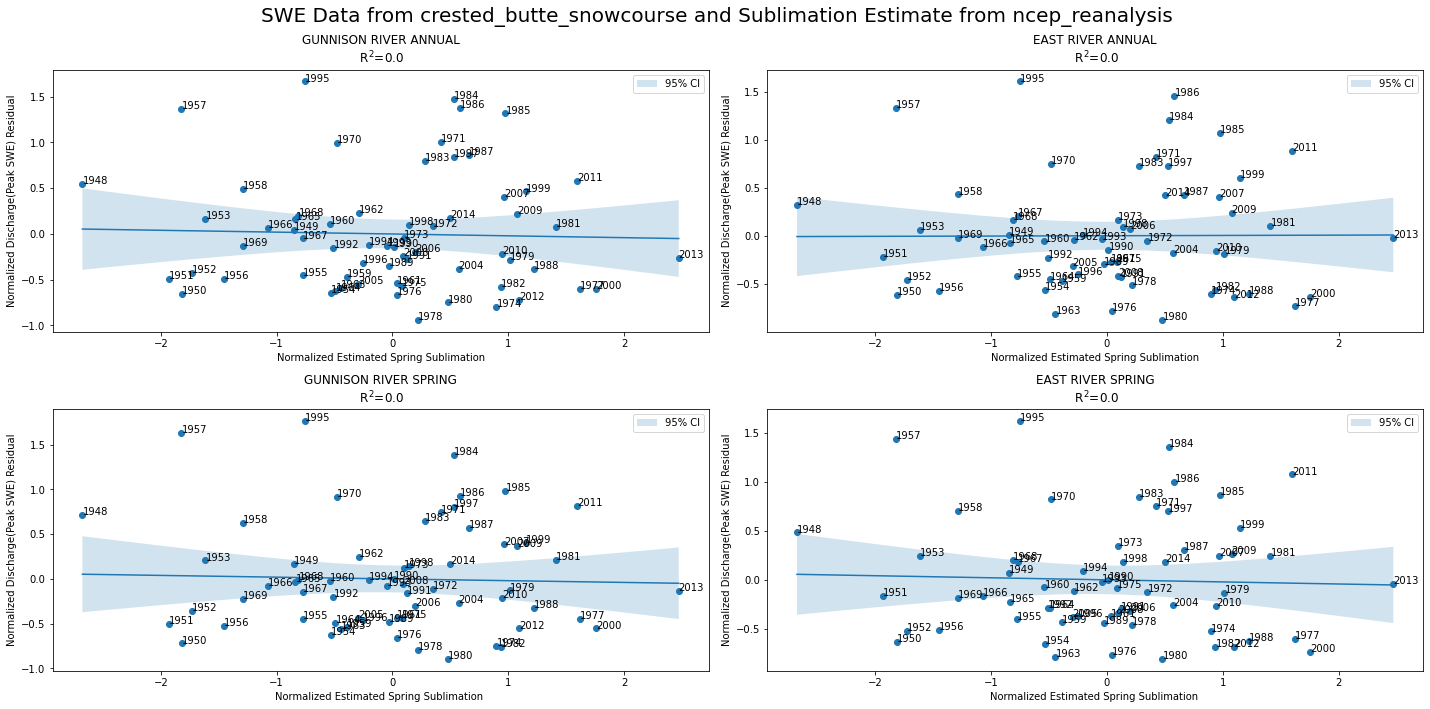

In [415]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}


plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=sublimation_ncep_totals,
                                        peak_swe_vals=crested_butte_max_swe_mm,
                                        start_year=1948,
                                        end_year=2014,
                                        labels={'swe_source':'crested_butte_snowcourse',
                                                'sublimation_source':'ncep_reanalysis'})

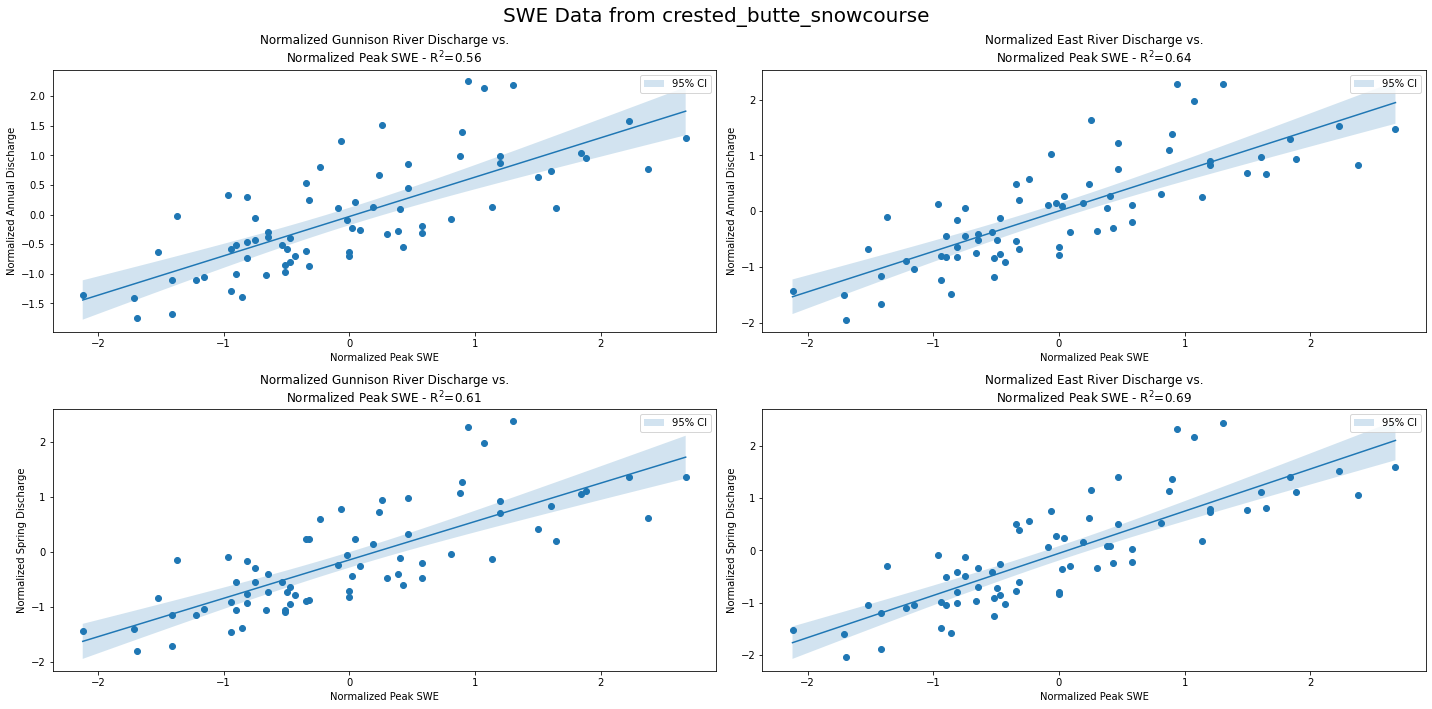

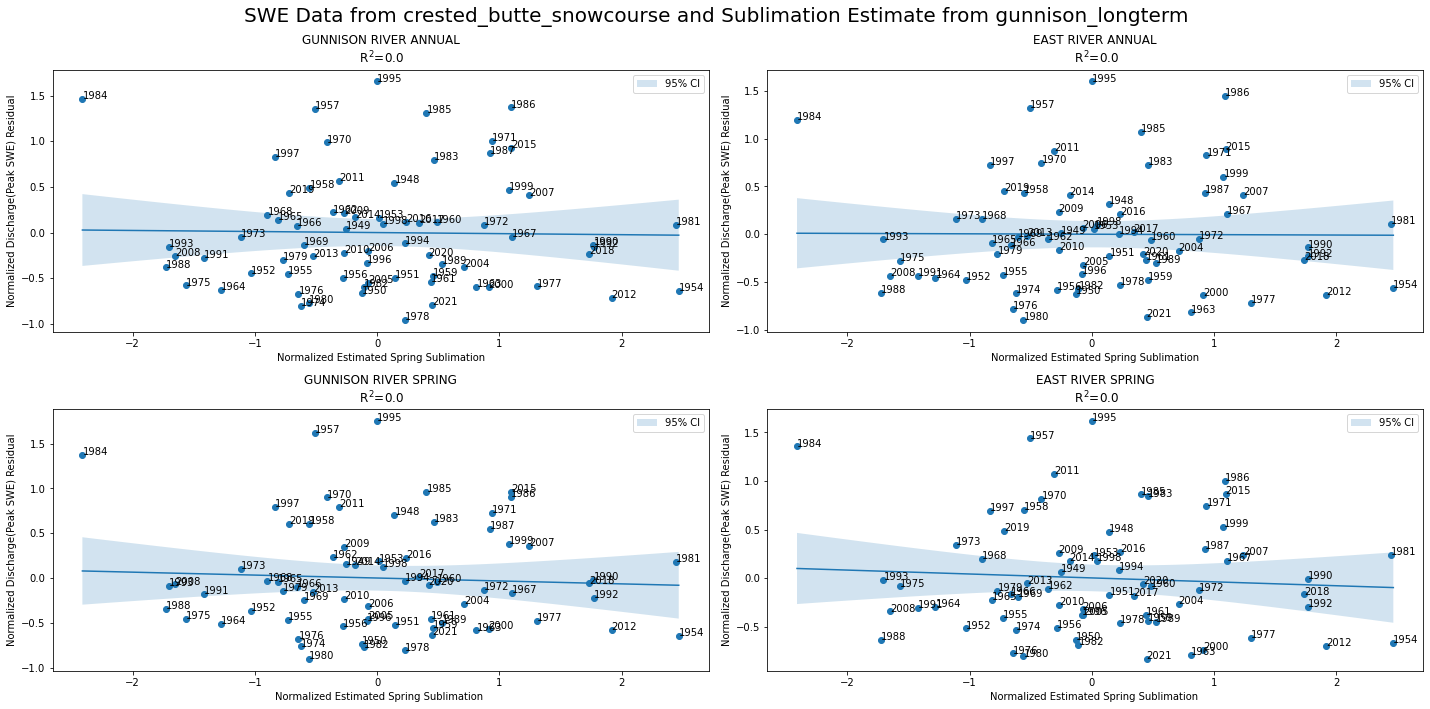

In [422]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}


plot_sublimation_discharge_relationship(sites=sites,
                                        sublimation_vals=sublimation_gunnison_totals,
                                        peak_swe_vals=crested_butte_max_swe_mm,
                                        start_year=1948,
                                        end_year=2021,
                                        labels={'swe_source':'crested_butte_snowcourse',
                                                'sublimation_source':'gunnison_longterm'})

### Try with the CIRES dataset estimate of sublimation

In [392]:
def cires_reanalysis_dynamic_load(product, product_code, start_year, end_year, coords, first_yr_start_date=None, first_yr_end_date=None):
    
    # Connect to FTP server
    print('Connecting to FTP server...')
    ftp = ftplib.FTP('ftp2.psl.noaa.gov') # Connect to NOAA's FTP
    ftp.login() # Anonymous login

    ftp.cwd(f'./Datasets/20thC_ReanV2c/Dailies/gaussian/{product}/')

    # Collect files into list
    print('Connected and pulled files...')
    files = ftp.nlst()
    ftp.close()
    print('Closed FTP session...')

    # Separate out files that I'm interested in
    product_files = []
    years = np.arange(start_year, end_year+1,1).astype(str)
    
    for file in files:
        if (product_code in file) & (file[-7:-3] in years):
            product_files.append(file)

    datasets = []
    # Concatenate on year and filter out unncessary values if desired
    for file in product_files:
        print(f'Fetching {file}...')
        # used this as reference: https://towardsdatascience.com/an-efficient-way-to-read-data-from-the-web-directly-into-python-a526a0b4f4cb
        url = f'ftp://ftp2.psl.noaa.gov/Datasets/20thC_ReanV2c/Dailies/gaussian/{product}/' + file
        req = urllib.request.Request(url)

        with urllib.request.urlopen(req) as resp:
            ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
            
            print(f'Filtering {file}...')
            # Transform coordiantes
            ds.coords['lon'] = ds.coords['lon'] - 180
            # Filter to western US
            ds = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
            
            # If provided, remove start year's dates
            if (first_yr_start_date) and (first_yr_end_date) and (f'{start_year}' in file):
                ds = ds.sel(time=slice(first_yr_start_date, first_yr_end_date))
            
            datasets.append(ds)
            print('Done!')
    return xr.concat(datasets, dim='time')

In [394]:
product = 'monolevel'
product_code = 'sbsno'
coords = (38.95615768432617, -106.98785400390625)
sub_df = cires_reanalysis_dynamic_load(product, product_code, 1988, 2015, coords)

daily_sublimation = sub_df.drop_dims('nbnds').to_pandas().groupby(sub_df.drop_dims('nbnds').to_pandas().index.date).mean()/2.837e6 * 24*3600
daily_sublimation.index = pd.to_datetime(daily_sublimation.index)
daily_sublimation['water_year'] = daily_sublimation.index.year.where(daily_sublimation.index.month < 10, daily_sublimation.index.year + 1).astype(int)
winter_cires_df = daily_sublimation.loc[daily_sublimation.index.month < 5 | ((daily_sublimation.index.month == 12) & (daily_sublimation.index.day > 1)) ]
winter_cires_df

Connecting to FTP server...
Connected and pulled files...
Closed FTP session...
Fetching sbsno.1988.nc...
Filtering sbsno.1988.nc...
Done!
Fetching sbsno.1989.nc...
Filtering sbsno.1989.nc...
Done!
Fetching sbsno.1990.nc...
Filtering sbsno.1990.nc...
Done!
Fetching sbsno.1991.nc...
Filtering sbsno.1991.nc...
Done!
Fetching sbsno.1992.nc...
Filtering sbsno.1992.nc...
Done!
Fetching sbsno.1993.nc...
Filtering sbsno.1993.nc...
Done!
Fetching sbsno.1994.nc...
Filtering sbsno.1994.nc...
Done!
Fetching sbsno.1995.nc...
Filtering sbsno.1995.nc...
Done!
Fetching sbsno.1996.nc...
Filtering sbsno.1996.nc...
Done!
Fetching sbsno.1997.nc...
Filtering sbsno.1997.nc...
Done!
Fetching sbsno.1998.nc...
Filtering sbsno.1998.nc...
Done!
Fetching sbsno.1999.nc...
Filtering sbsno.1999.nc...
Done!
Fetching sbsno.2000.nc...
Filtering sbsno.2000.nc...
Done!
Fetching sbsno.2001.nc...
Filtering sbsno.2001.nc...
Done!
Fetching sbsno.2002.nc...
Filtering sbsno.2002.nc...
Done!
Fetching sbsno.2003.nc...
Filtering

,lat,lon,sbsno,water_year
1988-01-01,1.189165,-3.254847,0.593867,1988
1988-01-02,1.189165,-3.254847,0.818470,1988
1988-01-03,1.189165,-3.254847,0.529150,1988
1988-01-04,1.189165,-3.254847,0.742334,1988
1988-01-05,1.189165,-3.254847,0.738527,1988
...,...,...,...,...
2014-04-26,1.189165,-3.254847,0.985971,2014
2014-04-27,1.189165,-3.254847,0.258865,2014
2014-04-28,1.189165,-3.254847,0.053296,2014
2014-04-29,1.189165,-3.254847,0.106591,2014


<AxesSubplot:xlabel='water_year'>

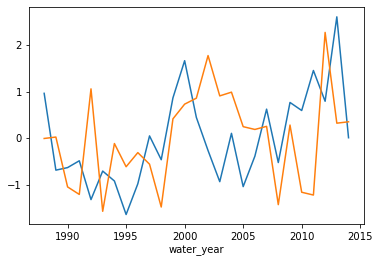

In [419]:
# This does not work very well...
sublimation_cires_totals = winter_cires_df.groupby(winter_cires_df.water_year).sum()['sbsno']
normalize_data(sublimation_ncep_totals.loc[1988:2014]).plot()
normalize_data(sublimation_taylor_totals.loc[1988:2014]).plot()

This does not seem to compare well...

### Grab NARR data and try looking at the same thing? Not working right now, not really interested in this though, can use this if needed https://github.com/xarray-contrib/xoak

In [584]:
def narr_reanalysis_dynamic_load(product, product_code, start_year, end_year, coords, first_yr_start_date=None, first_yr_end_date=None):
    
    # Connect to FTP server
    print('Connecting to FTP server...')
    ftp = ftplib.FTP('ftp2.psl.noaa.gov') # Connect to NOAA's FTP
    ftp.login() # Anonymous login

    ftp.cwd(f'./Datasets/NARR/Dailies/{product}/')

    # Collect files into list
    print('Connected and pulled files...')
    files = ftp.nlst()
    ftp.close()
    print('Closed FTP session...')

    # Separate out files that I'm interested in
    product_files = []
    years = np.arange(start_year, end_year+1,1).astype(str)
    
    for file in files:
        if (product_code in file) & (file[-7:-3] in years):
            product_files.append(file)

    datasets = []
    # Concatenate on year and filter out unncessary values if desired
    for file in product_files:
        print(f'Fetching {file}...')
        # used this as reference: https://towardsdatascience.com/an-efficient-way-to-read-data-from-the-web-directly-into-python-a526a0b4f4cb
        url = f'ftp://ftp2.psl.noaa.gov/Datasets/NARR/Dailies/{product}/' + file
        req = urllib.request.Request(url)

        with urllib.request.urlopen(req) as resp:
            ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
            
            # print(f'Filtering {file}...')
            # # Transform coordiantes
            # ds.coords['lon'] = ds.coords['lon'] - 180
            # # Filter to western US
            # ds = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
            
            # # If provided, remove start year's dates
            # if (first_yr_start_date) and (first_yr_end_date) and (f'{start_year}' in file):
            #     ds = ds.sel(time=slice(first_yr_start_date, first_yr_end_date))
            
            datasets.append(ds)
            print('Done!')
    return xr.concat(datasets, dim='time')

In [ ]:
product_codes = ['air.2m','rhum.2m', 'uwnd','vwnd']
coords = (38.95615768432617, -106.98785400390625)
for i,code in enumerate(product_codes):
    if i == 0:
        narr_ds = narr_reanalysis_dynamic_load('monolevel', code, 1979, 1980, coords, first_yr_start_date=None, first_yr_end_date=None)
        break
    else:
        tmp = narr_reanalysis_dynamic_load('monolevel', code, 1979, 1980, coords, first_yr_start_date=None, first_yr_end_date=None)
        narr_ds = xr.merge([narr_ds,tmp])
        break
# narr_ds['wspd'] = np.sqrt(narr_ds.uwnd**2 + narr_ds.vwnd**2)        